# 🚗 Automotive Concept Car Designer using DDPM

## Denoising Diffusion Probabilistic Models for Novel Vehicle Design Generation

**Objective:** Train a deep learning model to learn the underlying geometry of automobiles and synthesize unique, realistic car designs from random noise.

**Key Features:**
- Attention U-Net Architecture with Self-Attention layers
- Denoising Diffusion Probabilistic Model (DDPM)
- Stanford Cars Dataset (16,185 images, 196 classes)
- Latent Space Interpolation for hybrid car concepts

---

## Part 1: Setup and Imports

In [ ]:
# Install required packages for Hugging Face Diffusers
!pip install diffusers accelerate -q

import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
from pathlib import Path
from typing import Optional, Tuple, List

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid, save_image

# Hugging Face Diffusers
from diffusers import UNet2DModel, DDPMScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA A100-SXM4-40GB
Memory: 42.47 GB


In [ ]:
# ============================================
# Configuration
# ============================================
class Config:
    # Data
    DATA_DIR = "./cardataset"
    IMAGE_SIZE = 64  # Downsampled resolution
    CHANNELS = 3

    # Training
    BATCH_SIZE = 128  
    EPOCHS = 350  # Reduced epochs - Diffusers is more efficient
    LEARNING_RATE = 1e-4  # Slightly lower LR works better with warmup
    LR_WARMUP_STEPS = 500  # Warmup steps for learning rate

    # Diffusion (using Diffusers)
    TIMESTEPS = 1000
    BETA_SCHEDULE = "squaredcos_cap_v2"  # Cosine schedule - much better than linear!

    # Model - UNet2DModel from Diffusers
    # Architecture tuned for 64x64 images

    # Sampling
    NUM_SAMPLES = 16

    # Checkpoints
    SAVE_DIR = "./checkpoints"
    SAMPLE_DIR = "./samples"

    # Reproducibility
    SEED = 42

config = Config()

# Set seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(config.SEED)

# Create directories
os.makedirs(config.SAVE_DIR, exist_ok=True)
os.makedirs(config.SAMPLE_DIR, exist_ok=True)
print("Configuration loaded!")
print(f"Using beta schedule: {config.BETA_SCHEDULE} (cosine - better than linear!)")
print(f"Training for {config.EPOCHS} epochs with LR warmup")

Configuration loaded!
Using beta schedule: squaredcos_cap_v2 (cosine - better than linear!)
Training for 350 epochs with LR warmup


## Part 2: Data Loading and Preprocessing

We'll first download the Stanford Cars Dataset from Kaggle, then apply the following preprocessing:
- Resize to 64x64 pixels
- Normalize to [-1, 1] range
- Random horizontal flips for augmentation

In [ ]:
import kagglehub

# ============================================
# Download Stanford Cars Dataset from Kaggle
# ============================================
# Download latest version
print("Downloading Stanford Cars Dataset from Kaggle...")
dataset_path = kagglehub.dataset_download("eduardo4jesus/stanford-cars-dataset")
print(f"Path to dataset files: {dataset_path}")

# Update config with the downloaded path
config.DATA_DIR = dataset_path
print(f"Updated DATA_DIR to: {config.DATA_DIR}")

100%|██████████| 1.82G/1.82G [01:24<00:00, 23.3MB/s]

Extracting files...


In [ ]:
class StanfordCarsDataset(Dataset):
    """
    Custom Dataset for Stanford Cars.
    Loads images from train and test directories.
    Handles various directory structures from different sources.
    """
    def __init__(self, root_dir, transform=None, split='both'):
        """
        Args:
            root_dir: Path to the dataset root
            transform: Transformations to apply
            split: 'train', 'test', or 'both'
        """
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.image_paths = []

        # Try different possible directory structures
        possible_train_dirs = [
            self.root_dir / 'cars_train',
            self.root_dir / 'car_data' / 'car_data' / 'train',
            self.root_dir / 'car_data' / 'train',
            self.root_dir / 'train',
        ]

        possible_test_dirs = [
            self.root_dir / 'cars_test',
            self.root_dir / 'car_data' / 'car_data' / 'test',
            self.root_dir / 'car_data' / 'test',
            self.root_dir / 'test',
        ]

        # Collect image paths from train directories
        if split in ['train', 'both']:
            for train_dir in possible_train_dirs:
                if train_dir.exists():
                    print(f"Found train directory: {train_dir}")
                    # Check for subdirectories (class folders)
                    subdirs = [d for d in train_dir.iterdir() if d.is_dir()]
                    if subdirs:
                        # Images are in class subdirectories
                        for subdir in subdirs:
                            self.image_paths.extend(list(subdir.glob('*.jpg')))
                            self.image_paths.extend(list(subdir.glob('*.jpeg')))
                            self.image_paths.extend(list(subdir.glob('*.png')))
                    else:
                        # Images are directly in the directory
                        self.image_paths.extend(list(train_dir.glob('*.jpg')))
                        self.image_paths.extend(list(train_dir.glob('*.jpeg')))
                        self.image_paths.extend(list(train_dir.glob('*.png')))
                    break

        # Collect image paths from test directories
        if split in ['test', 'both']:
            for test_dir in possible_test_dirs:
                if test_dir.exists():
                    print(f"Found test directory: {test_dir}")
                    # Check for subdirectories (class folders)
                    subdirs = [d for d in test_dir.iterdir() if d.is_dir()]
                    if subdirs:
                        # Images are in class subdirectories
                        for subdir in subdirs:
                            self.image_paths.extend(list(subdir.glob('*.jpg')))
                            self.image_paths.extend(list(subdir.glob('*.jpeg')))
                            self.image_paths.extend(list(subdir.glob('*.png')))
                    else:
                        # Images are directly in the directory
                        self.image_paths.extend(list(test_dir.glob('*.jpg')))
                        self.image_paths.extend(list(test_dir.glob('*.jpeg')))
                        self.image_paths.extend(list(test_dir.glob('*.png')))
                    break

        # If still no images found, search recursively
        if len(self.image_paths) == 0:
            print("Searching recursively for images...")
            self.image_paths.extend(list(self.root_dir.rglob('*.jpg')))
            self.image_paths.extend(list(self.root_dir.rglob('*.jpeg')))
            self.image_paths.extend(list(self.root_dir.rglob('*.png')))

        print(f"Loaded {len(self.image_paths)} images from {split} split")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Scale to [-1, 1]
])

val_transform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# List contents of downloaded directory to understand structure
print("\nExploring dataset directory structure:")
for item in Path(config.DATA_DIR).iterdir():
    print(f"  {item.name}{'/' if item.is_dir() else ''}")
    if item.is_dir():
        for subitem in list(item.iterdir())[:5]:  # Show first 5 items
            print(f"    {subitem.name}{'/' if subitem.is_dir() else ''}")
        if len(list(item.iterdir())) > 5:
            print(f"    ... and {len(list(item.iterdir())) - 5} more items")


Loading datasets...
Found train directory: /root/.cache/kagglehub/datasets/eduardo4jesus/stanford-cars-dataset/versions/1/cars_train
Found test directory: /root/.cache/kagglehub/datasets/eduardo4jesus/stanford-cars-dataset/versions/1/cars_test
Loaded 16185 images from both split

Dataset Statistics:
Total images: 16185
Batches per epoch: 126
Batch size: 128


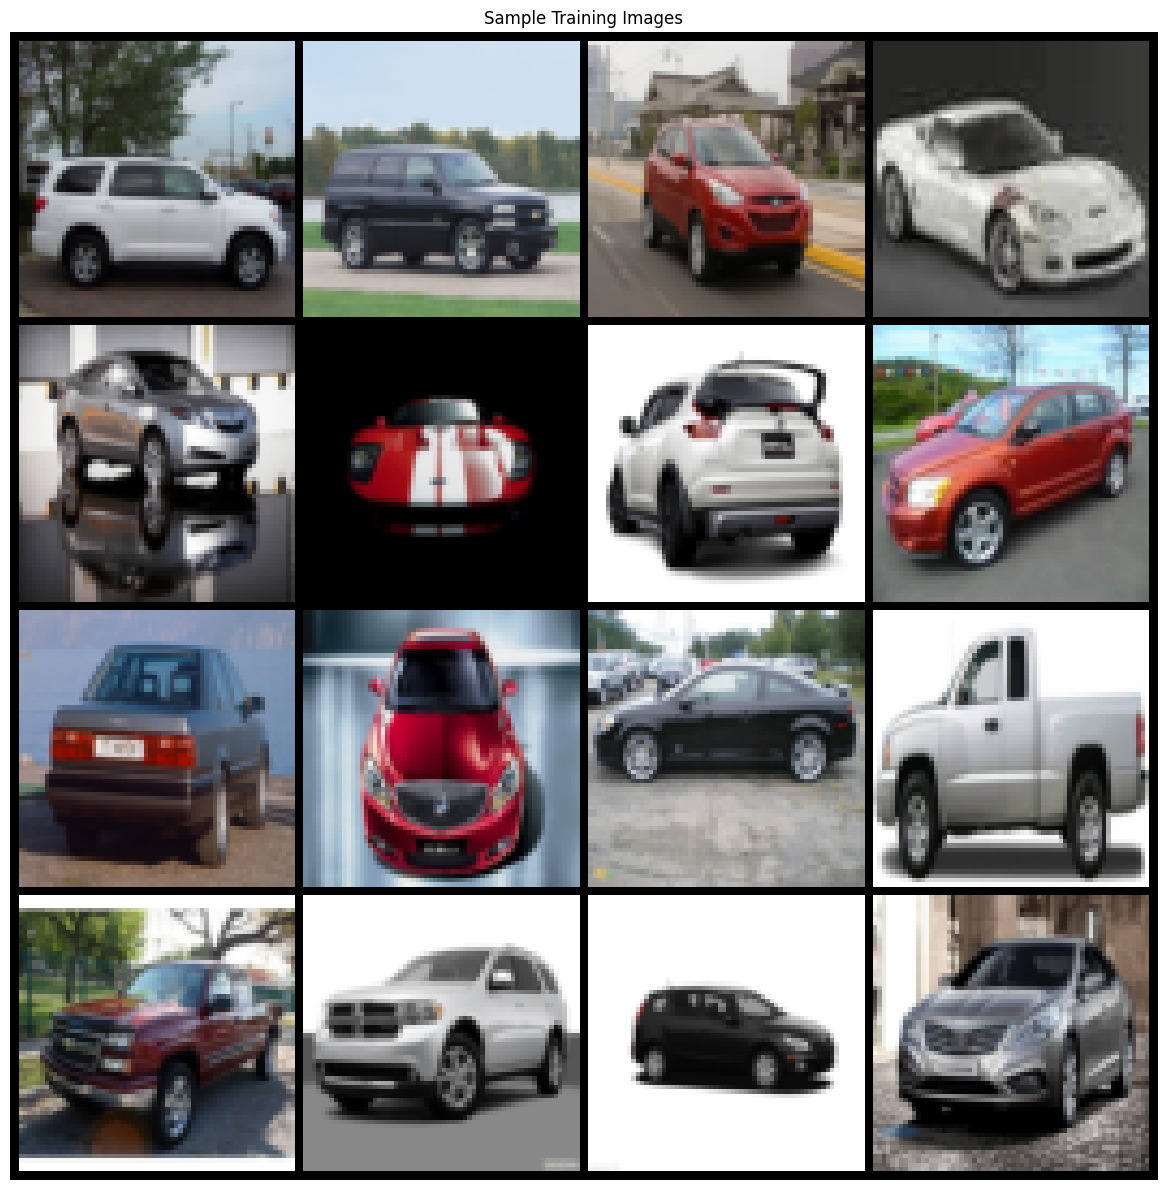

In [ ]:
# Load datasets
print("\nLoading datasets...")

# Combine train and test for larger training set
full_dataset = StanfordCarsDataset(
    root_dir=config.DATA_DIR,
    transform=train_transform,
    split='both'
)

# Verify we have images
if len(full_dataset) == 0:
    raise ValueError("No images found! Please check the dataset path and structure.")

# Create DataLoaders
train_loader = DataLoader(
    full_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True
)

print(f"\nDataset Statistics:")
print(f"Total images: {len(full_dataset)}")
print(f"Batches per epoch: {len(train_loader)}")
print(f"Batch size: {config.BATCH_SIZE}")

# Visualize some samples
def show_images(images, title="Sample Images", nrow=4):
    """Display a grid of images"""
    # Denormalize from [-1, 1] to [0, 1]
    images = (images + 1) / 2
    images = torch.clamp(images, 0, 1)

    grid = make_grid(images, nrow=nrow, padding=2)
    plt.figure(figsize=(12, 12))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show sample images from dataset
sample_batch = next(iter(train_loader))
show_images(sample_batch[:16], title="Sample Training Images", nrow=4)

## Part 3: Model Architecture

### Attention U-Net for Diffusion

The architecture consists of:
1. **Sinusoidal Time Embeddings** - Encode diffusion timestep
2. **Residual Blocks** - With time embedding injection
3. **Self-Attention Layers** - At bottleneck for global consistency
4. **U-Net Encoder-Decoder** - Symmetric architecture with skip connections

We will use UNet2DModel from Hugging Face Diffusers instead.

## Part 4: Diffusion Process (DDPM)

### Forward Process (Adding Noise)
The forward process gradually adds Gaussian noise to the image over T timesteps:

$$q(x_t | x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_t}x_{t-1}, \beta_t \mathbf{I})$$

### Reverse Process (Denoising)
The model learns to reverse this process by predicting the noise:

$$p_\theta(x_{t-1} | x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \sigma_t^2 \mathbf{I})$$

In [ ]:
# ============================================
# Diffusion Process using DDPMScheduler
# ============================================

# The noise_scheduler (DDPMScheduler) was initialized in the model cell above
# Here we define helper functions for the diffusion process

def forward_diffusion(scheduler, x_0, t, noise=None):
    """
    Forward diffusion process: q(x_t | x_0) using DDPMScheduler

    Args:
        scheduler: DDPMScheduler instance
        x_0: Original clean image [B, C, H, W]
        t: Timestep [B]
        noise: Optional pre-sampled noise

    Returns:
        x_t: Noisy image at timestep t
        noise: The noise that was added
    """
    if noise is None:
        noise = torch.randn_like(x_0)

    # Add noise using scheduler's add_noise method
    x_t = scheduler.add_noise(x_0, noise, t)

    return x_t, noise


@torch.no_grad()
def sample(model, scheduler, n_samples, channels=3, img_size=64, device='cuda', show_progress=True):
    """
    Generate samples using reverse diffusion with DDPMScheduler.

    Args:
        model: Trained noise prediction model (UNet2DModel)
        scheduler: DDPMScheduler instance
        n_samples: Number of samples to generate
        channels: Number of image channels
        img_size: Image resolution
        device: Device to use
        show_progress: Whether to show progress bar

    Returns:
        Generated images [n_samples, C, H, W]
    """
    model.eval()

    # Start from pure noise
    x = torch.randn(n_samples, channels, img_size, img_size, device=device)

    # Set scheduler timesteps
    scheduler.set_timesteps(config.TIMESTEPS, device=device)

    # Reverse diffusion
    timesteps = scheduler.timesteps
    if show_progress:
        timesteps = tqdm(timesteps, desc="Sampling")

    for t in timesteps:
        # Predict noise
        model_output = model(x, t).sample

        # Compute previous sample using scheduler
        x = scheduler.step(model_output, t, x).prev_sample

    # Clamp to valid range
    x = torch.clamp(x, -1, 1)

    return x


print("Diffusion process initialized with DDPMScheduler!")
print(f"Using {config.BETA_SCHEDULE} beta schedule (much better than linear!)")
print(f"Timesteps: {config.TIMESTEPS}")

Diffusion process initialized with DDPMScheduler!
Using squaredcos_cap_v2 beta schedule (much better than linear!)
Timesteps: 1000


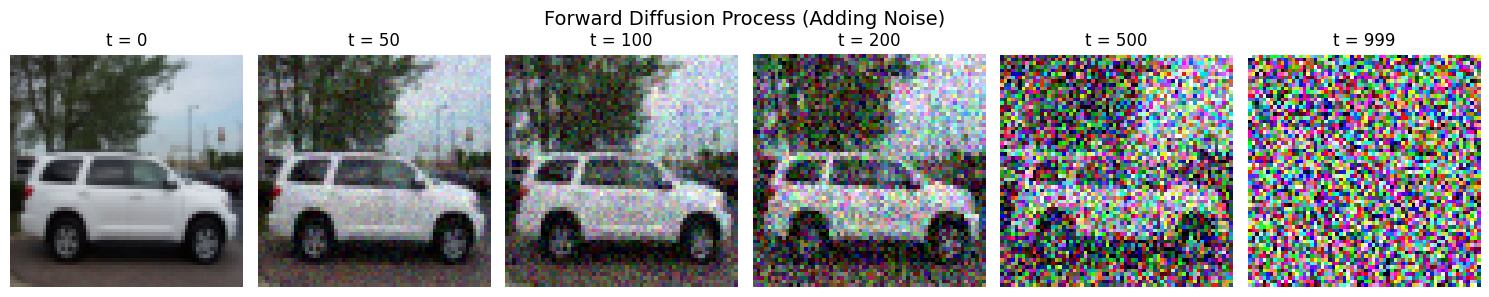


Visualized forward diffusion with squaredcos_cap_v2 schedule
Notice how the cosine schedule preserves more signal at higher timesteps!


In [ ]:
# Visualize forward diffusion process
def visualize_forward_diffusion(image, scheduler, steps=[0, 50, 100, 200, 500, 999]):
    """
    Visualize how noise is added over time using DDPMScheduler.
    """
    fig, axes = plt.subplots(1, len(steps), figsize=(15, 3))

    for i, t in enumerate(steps):
        t_tensor = torch.tensor([t], device=device)
        noisy_img, _ = forward_diffusion(scheduler, image.unsqueeze(0).to(device), t_tensor)

        # Denormalize
        img = (noisy_img.squeeze().cpu() + 1) / 2
        img = torch.clamp(img, 0, 1)

        axes[i].imshow(img.permute(1, 2, 0).numpy())
        axes[i].set_title(f't = {t}')
        axes[i].axis('off')

    plt.suptitle('Forward Diffusion Process (Adding Noise)', fontsize=14)
    plt.tight_layout()
    plt.show()

# Create a temporary scheduler for visualization
# (The main noise_scheduler will be created in the training cell)
temp_scheduler = DDPMScheduler(
    num_train_timesteps=config.TIMESTEPS,
    beta_schedule=config.BETA_SCHEDULE,
    prediction_type="epsilon",
)

# Get a sample image and visualize diffusion
sample_image = sample_batch[0]
visualize_forward_diffusion(sample_image, temp_scheduler)

print(f"\nVisualized forward diffusion with {config.BETA_SCHEDULE} schedule")
print("Notice how the cosine schedule preserves more signal at higher timesteps!")

## Part 5: Training Loop

### Training Objective
The model is trained to predict the noise $\epsilon$ added during the forward process:

$$\mathcal{L} = \mathbb{E}_{x_0, \epsilon, t} \left[ \| \epsilon - \epsilon_\theta(x_t, t) \|^2 \right]$$

In [ ]:
# ============================================
# Exponential Moving Average (EMA)
# ============================================

class EMA:
    """
    Exponential Moving Average for model weights.
    Helps produce smoother, higher-quality samples.
    """
    def __init__(self, model, decay=0.9999):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}

        # Initialize shadow weights
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self):
        """Update shadow weights with exponential moving average"""
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = (
                    self.decay * self.shadow[name] + (1 - self.decay) * param.data
                )

    def apply_shadow(self):
        """Apply shadow weights to model for sampling"""
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.backup[name] = param.data.clone()
                param.data = self.shadow[name]

    def restore(self):
        """Restore original weights after sampling"""
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                param.data = self.backup[name]
        self.backup = {}

In [ ]:
# ============================================
# Training Function
# ============================================

def train_epoch(model, dataloader, optimizer, diffusion, device, epoch):
    """
    Train for one epoch.

    Args:
        model: The noise prediction model
        dataloader: Training data loader
        optimizer: Optimizer
        diffusion: Diffusion process handler
        device: Device to train on
        epoch: Current epoch number

    Returns:
        Average loss for the epoch
    """
    model.train()
    total_loss = 0

    pbar = tqdm(dataloader, desc=f"Epoch {epoch}")

    for batch_idx, images in enumerate(pbar):
        images = images.to(device)
        batch_size = images.shape[0]

        # Sample random timesteps
        t = torch.randint(0, diffusion.timesteps, (batch_size,), device=device).long()

        # Get noisy images and noise
        x_t, noise = diffusion.forward_diffusion(images, t)

        # Predict noise
        predicted_noise = model(x_t, t)

        # Calculate loss (MSE between actual and predicted noise)
        loss = F.mse_loss(predicted_noise, noise)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    return total_loss / len(dataloader)


def save_checkpoint(model, optimizer, epoch, loss, path):
    """Save model checkpoint"""
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, path)
    print(f"Checkpoint saved: {path}")


def load_checkpoint(model, optimizer, path):
    """Load model checkpoint"""
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch'], checkpoint['loss']

In [ ]:
# ============================================
# Training Loop
# ============================================

# Initialize Model with Hugging Face Diffusers UNet2DModel
# ============================================

# UNet2DModel from Diffusers - optimized architecture for diffusion models
model = UNet2DModel(
    sample_size=config.IMAGE_SIZE,  # 64x64
    in_channels=config.CHANNELS,
    out_channels=config.CHANNELS,
    layers_per_block=2,
    block_out_channels=(128, 256, 256, 512),  # Channel progression
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # Attention at 16x16
        "AttnDownBlock2D",  # Attention at 8x8
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
    attention_head_dim=8,
    norm_num_groups=32,
).to(device)

# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model: UNet2DModel from Hugging Face Diffusers")
print(f"Model Parameters: {count_parameters(model):,}")

# Initialize DDPMScheduler - handles all diffusion math
noise_scheduler = DDPMScheduler(
    num_train_timesteps=config.TIMESTEPS,
    beta_schedule=config.BETA_SCHEDULE,  # "squaredcos_cap_v2" - cosine schedule
    prediction_type="epsilon",  # Predict noise
)

print(f"Scheduler: DDPMScheduler with {config.BETA_SCHEDULE} schedule")
print(f"Timesteps: {config.TIMESTEPS}")

# Optimizer with learning rate warmup
optimizer = torch.optim.AdamW(model.parameters(), lr=config.LEARNING_RATE)

# Learning rate scheduler with warmup
total_training_steps = len(train_loader) * config.EPOCHS
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.LR_WARMUP_STEPS,
    num_training_steps=total_training_steps,
)

print(f"\nOptimizer: AdamW with LR={config.LEARNING_RATE}")
print(f"LR Schedule: Cosine with {config.LR_WARMUP_STEPS} warmup steps")
print(f"Total training steps: {total_training_steps}")

# EMA for better sample quality
ema = EMA(model, decay=0.9999)

# Test forward pass
with torch.no_grad():
    test_input = torch.randn(2, 3, 64, 64).to(device)
    test_time = torch.randint(0, 1000, (2,)).to(device)
    test_output = model(test_input, test_time).sample
    print(f"\nInput shape: {test_input.shape}")
    print(f"Output shape: {test_output.shape}")
    print("Model test passed! ✓")

Model: UNet2DModel from Hugging Face Diffusers
Model Parameters: 74,051,331
Scheduler: DDPMScheduler with squaredcos_cap_v2 schedule
Timesteps: 1000

Optimizer: AdamW with LR=0.0001
LR Schedule: Cosine with 500 warmup steps
Total training steps: 44100

Input shape: torch.Size([2, 3, 64, 64])
Output shape: torch.Size([2, 3, 64, 64])
Model test passed! ✓


In [ ]:
# Training history
history = {
    'train_loss': [],
    'lr': []
}

# Training loop
best_loss = float('inf')
global_step = 0

print(f"Starting training with Diffusers UNet2DModel and DDPMScheduler")
print(f"Using {config.BETA_SCHEDULE} schedule for better gradient flow!\n")

for epoch in range(1, config.EPOCHS + 1):
    model.train()
    total_loss = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{config.EPOCHS}")

    for batch_idx, images in enumerate(pbar):
        images = images.to(device)
        batch_size = images.shape[0]

        # Sample random timesteps
        t = torch.randint(0, noise_scheduler.config.num_train_timesteps, (batch_size,), device=device).long()

        # Add noise using DDPMScheduler
        noise = torch.randn_like(images)
        noisy_images = noise_scheduler.add_noise(images, noise, t)

        # Predict noise using UNet2DModel
        noise_pred = model(noisy_images, t, return_dict=False)[0]

        # Calculate loss (MSE between actual and predicted noise)
        loss = F.mse_loss(noise_pred, noise)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        lr_scheduler.step()  # Update learning rate with warmup

        # Update EMA
        ema.update()

        total_loss += loss.item()
        global_step += 1

        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'lr': f'{lr_scheduler.get_last_lr()[0]:.2e}'
        })

    # Record epoch stats
    avg_loss = total_loss / len(train_loader)
    current_lr = lr_scheduler.get_last_lr()[0]
    history['train_loss'].append(avg_loss)
    history['lr'].append(current_lr)

    print(f"Epoch {epoch}/{config.EPOCHS} - Loss: {avg_loss:.4f} - LR: {current_lr:.2e}")

    # Save checkpoint and generate samples every 10 epochs
    if epoch % 10 == 0:
        save_checkpoint(
            model, optimizer, epoch, avg_loss,
            os.path.join(config.SAVE_DIR, f'checkpoint_epoch_{epoch}.pt')
        )

        # Generate samples with EMA weights
        ema.apply_shadow()
        samples = sample(model, noise_scheduler, n_samples=16, img_size=config.IMAGE_SIZE, device=device)
        ema.restore()

        # Save sample grid
        samples_denorm = (samples + 1) / 2
        save_image(
            samples_denorm,
            os.path.join(config.SAMPLE_DIR, f'samples_epoch_{epoch}.png'),
            nrow=4
        )
        print(f"Samples saved to {config.SAMPLE_DIR}/samples_epoch_{epoch}.png")

    # Save best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        save_checkpoint(
            model, optimizer, epoch, avg_loss,
            os.path.join(config.SAVE_DIR, 'best_model.pt')
        )

print("\nTraining complete!")
print(f"Best loss: {best_loss:.4f}")

Starting training with Diffusers UNet2DModel and DDPMScheduler
Using squaredcos_cap_v2 schedule for better gradient flow!



Epoch 1/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 1/350 - Loss: 0.4981 - LR: 2.52e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 2/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 2/350 - Loss: 0.1076 - LR: 5.04e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 3/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 3/350 - Loss: 0.0803 - LR: 7.56e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 4/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 4/350 - Loss: 0.0667 - LR: 1.00e-04
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 5/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 5/350 - Loss: 0.0611 - LR: 1.00e-04
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 6/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 6/350 - Loss: 0.0588 - LR: 1.00e-04
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 7/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 7/350 - Loss: 0.0547 - LR: 1.00e-04
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 8/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 8/350 - Loss: 0.0531 - LR: 1.00e-04
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 9/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 9/350 - Loss: 0.0518 - LR: 9.99e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 10/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 10/350 - Loss: 0.0520 - LR: 9.99e-05
Checkpoint saved: ./checkpoints/checkpoint_epoch_10.pt


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to ./samples/samples_epoch_10.png


Epoch 11/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 11/350 - Loss: 0.0496 - LR: 9.99e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 12/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 12/350 - Loss: 0.0483 - LR: 9.99e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 13/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 13/350 - Loss: 0.0483 - LR: 9.98e-05


Epoch 14/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 14/350 - Loss: 0.0478 - LR: 9.98e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 15/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 15/350 - Loss: 0.0473 - LR: 9.97e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 16/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 16/350 - Loss: 0.0466 - LR: 9.97e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 17/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 17/350 - Loss: 0.0466 - LR: 9.97e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 18/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 18/350 - Loss: 0.0458 - LR: 9.96e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 19/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 19/350 - Loss: 0.0463 - LR: 9.95e-05


Epoch 20/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 20/350 - Loss: 0.0461 - LR: 9.95e-05
Checkpoint saved: ./checkpoints/checkpoint_epoch_20.pt


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to ./samples/samples_epoch_20.png


Epoch 21/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 21/350 - Loss: 0.0452 - LR: 9.94e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 22/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 22/350 - Loss: 0.0448 - LR: 9.93e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 23/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 23/350 - Loss: 0.0446 - LR: 9.93e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 24/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 24/350 - Loss: 0.0441 - LR: 9.92e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 25/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 25/350 - Loss: 0.0442 - LR: 9.91e-05


Epoch 26/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 26/350 - Loss: 0.0428 - LR: 9.90e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 27/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 27/350 - Loss: 0.0430 - LR: 9.89e-05


Epoch 28/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 28/350 - Loss: 0.0430 - LR: 9.88e-05


Epoch 29/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 29/350 - Loss: 0.0440 - LR: 9.87e-05


Epoch 30/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 30/350 - Loss: 0.0444 - LR: 9.86e-05
Checkpoint saved: ./checkpoints/checkpoint_epoch_30.pt


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to ./samples/samples_epoch_30.png


Epoch 31/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 31/350 - Loss: 0.0427 - LR: 9.85e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 32/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 32/350 - Loss: 0.0434 - LR: 9.84e-05


Epoch 33/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 33/350 - Loss: 0.0429 - LR: 9.83e-05


Epoch 34/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 34/350 - Loss: 0.0428 - LR: 9.82e-05


Epoch 35/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 35/350 - Loss: 0.0420 - LR: 9.80e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 36/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 36/350 - Loss: 0.0420 - LR: 9.79e-05


Epoch 37/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 37/350 - Loss: 0.0424 - LR: 9.78e-05


Epoch 38/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 38/350 - Loss: 0.0435 - LR: 9.76e-05


Epoch 39/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 39/350 - Loss: 0.0421 - LR: 9.75e-05


Epoch 40/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 40/350 - Loss: 0.0424 - LR: 9.73e-05
Checkpoint saved: ./checkpoints/checkpoint_epoch_40.pt


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to ./samples/samples_epoch_40.png


Epoch 41/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 41/350 - Loss: 0.0422 - LR: 9.72e-05


Epoch 42/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 42/350 - Loss: 0.0428 - LR: 9.70e-05


Epoch 43/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 43/350 - Loss: 0.0418 - LR: 9.69e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 44/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 44/350 - Loss: 0.0422 - LR: 9.67e-05


Epoch 45/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 45/350 - Loss: 0.0417 - LR: 9.66e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 46/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 46/350 - Loss: 0.0423 - LR: 9.64e-05


Epoch 47/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 47/350 - Loss: 0.0417 - LR: 9.62e-05


Epoch 48/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 48/350 - Loss: 0.0423 - LR: 9.61e-05


Epoch 49/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 49/350 - Loss: 0.0418 - LR: 9.59e-05


Epoch 50/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 50/350 - Loss: 0.0419 - LR: 9.57e-05
Checkpoint saved: ./checkpoints/checkpoint_epoch_50.pt


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to ./samples/samples_epoch_50.png


Epoch 51/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 51/350 - Loss: 0.0410 - LR: 9.55e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 52/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 52/350 - Loss: 0.0418 - LR: 9.53e-05


Epoch 53/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 53/350 - Loss: 0.0401 - LR: 9.51e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 54/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 54/350 - Loss: 0.0409 - LR: 9.49e-05


Epoch 55/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 55/350 - Loss: 0.0415 - LR: 9.47e-05


Epoch 56/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 56/350 - Loss: 0.0413 - LR: 9.45e-05


Epoch 57/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 57/350 - Loss: 0.0409 - LR: 9.43e-05


Epoch 58/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 58/350 - Loss: 0.0410 - LR: 9.41e-05


Epoch 59/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 59/350 - Loss: 0.0412 - LR: 9.39e-05


Epoch 60/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 60/350 - Loss: 0.0406 - LR: 9.37e-05
Checkpoint saved: ./checkpoints/checkpoint_epoch_60.pt


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to ./samples/samples_epoch_60.png


Epoch 61/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 61/350 - Loss: 0.0405 - LR: 9.34e-05


Epoch 62/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 62/350 - Loss: 0.0410 - LR: 9.32e-05


Epoch 63/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 63/350 - Loss: 0.0407 - LR: 9.30e-05


Epoch 64/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 64/350 - Loss: 0.0403 - LR: 9.28e-05


Epoch 65/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 65/350 - Loss: 0.0398 - LR: 9.25e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 66/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 66/350 - Loss: 0.0399 - LR: 9.23e-05


Epoch 67/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 67/350 - Loss: 0.0411 - LR: 9.20e-05


Epoch 68/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 68/350 - Loss: 0.0404 - LR: 9.18e-05


Epoch 69/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 69/350 - Loss: 0.0407 - LR: 9.15e-05


Epoch 70/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 70/350 - Loss: 0.0399 - LR: 9.13e-05
Checkpoint saved: ./checkpoints/checkpoint_epoch_70.pt


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to ./samples/samples_epoch_70.png


Epoch 71/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 71/350 - Loss: 0.0400 - LR: 9.10e-05


Epoch 72/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 72/350 - Loss: 0.0399 - LR: 9.08e-05


Epoch 73/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 73/350 - Loss: 0.0399 - LR: 9.05e-05


Epoch 74/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 74/350 - Loss: 0.0406 - LR: 9.02e-05


Epoch 75/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 75/350 - Loss: 0.0401 - LR: 9.00e-05


Epoch 76/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 76/350 - Loss: 0.0397 - LR: 8.97e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 77/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 77/350 - Loss: 0.0396 - LR: 8.94e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 78/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 78/350 - Loss: 0.0400 - LR: 8.91e-05


Epoch 79/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 79/350 - Loss: 0.0405 - LR: 8.88e-05


Epoch 80/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 80/350 - Loss: 0.0401 - LR: 8.86e-05
Checkpoint saved: ./checkpoints/checkpoint_epoch_80.pt


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to ./samples/samples_epoch_80.png


Epoch 81/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 81/350 - Loss: 0.0404 - LR: 8.83e-05


Epoch 82/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 82/350 - Loss: 0.0395 - LR: 8.80e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 83/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 83/350 - Loss: 0.0412 - LR: 8.77e-05


Epoch 84/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 84/350 - Loss: 0.0393 - LR: 8.74e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 85/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 85/350 - Loss: 0.0396 - LR: 8.71e-05


Epoch 86/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 86/350 - Loss: 0.0398 - LR: 8.68e-05


Epoch 87/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 87/350 - Loss: 0.0391 - LR: 8.65e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 88/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 88/350 - Loss: 0.0389 - LR: 8.61e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 89/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 89/350 - Loss: 0.0394 - LR: 8.58e-05


Epoch 90/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 90/350 - Loss: 0.0389 - LR: 8.55e-05
Checkpoint saved: ./checkpoints/checkpoint_epoch_90.pt


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to ./samples/samples_epoch_90.png
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 91/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 91/350 - Loss: 0.0391 - LR: 8.52e-05


Epoch 92/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 92/350 - Loss: 0.0401 - LR: 8.49e-05


Epoch 93/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 93/350 - Loss: 0.0388 - LR: 8.45e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 94/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 94/350 - Loss: 0.0395 - LR: 8.42e-05


Epoch 95/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 95/350 - Loss: 0.0380 - LR: 8.39e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 96/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 96/350 - Loss: 0.0389 - LR: 8.35e-05


Epoch 97/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 97/350 - Loss: 0.0386 - LR: 8.32e-05


Epoch 98/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 98/350 - Loss: 0.0398 - LR: 8.29e-05


Epoch 99/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 99/350 - Loss: 0.0400 - LR: 8.25e-05


Epoch 100/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 100/350 - Loss: 0.0391 - LR: 8.22e-05
Checkpoint saved: ./checkpoints/checkpoint_epoch_100.pt


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to ./samples/samples_epoch_100.png


Epoch 101/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 101/350 - Loss: 0.0384 - LR: 8.18e-05


Epoch 102/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 102/350 - Loss: 0.0383 - LR: 8.15e-05


Epoch 103/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 103/350 - Loss: 0.0396 - LR: 8.11e-05


Epoch 104/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 104/350 - Loss: 0.0386 - LR: 8.08e-05


Epoch 105/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 105/350 - Loss: 0.0386 - LR: 8.04e-05


Epoch 106/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 106/350 - Loss: 0.0390 - LR: 8.00e-05


Epoch 107/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 107/350 - Loss: 0.0387 - LR: 7.97e-05


Epoch 108/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 108/350 - Loss: 0.0382 - LR: 7.93e-05


Epoch 109/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 109/350 - Loss: 0.0390 - LR: 7.89e-05


Epoch 110/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 110/350 - Loss: 0.0389 - LR: 7.86e-05
Checkpoint saved: ./checkpoints/checkpoint_epoch_110.pt


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to ./samples/samples_epoch_110.png


Epoch 111/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 111/350 - Loss: 0.0393 - LR: 7.82e-05


Epoch 112/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 112/350 - Loss: 0.0383 - LR: 7.78e-05


Epoch 113/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 113/350 - Loss: 0.0388 - LR: 7.74e-05


Epoch 114/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 114/350 - Loss: 0.0387 - LR: 7.71e-05


Epoch 115/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 115/350 - Loss: 0.0382 - LR: 7.67e-05


Epoch 116/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 116/350 - Loss: 0.0395 - LR: 7.63e-05


Epoch 117/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 117/350 - Loss: 0.0385 - LR: 7.59e-05


Epoch 118/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 118/350 - Loss: 0.0379 - LR: 7.55e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 119/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 119/350 - Loss: 0.0396 - LR: 7.51e-05


Epoch 120/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 120/350 - Loss: 0.0388 - LR: 7.47e-05
Checkpoint saved: ./checkpoints/checkpoint_epoch_120.pt


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to ./samples/samples_epoch_120.png


Epoch 121/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 121/350 - Loss: 0.0382 - LR: 7.43e-05


Epoch 122/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 122/350 - Loss: 0.0383 - LR: 7.39e-05


Epoch 123/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 123/350 - Loss: 0.0389 - LR: 7.35e-05


Epoch 124/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 124/350 - Loss: 0.0374 - LR: 7.31e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 125/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 125/350 - Loss: 0.0392 - LR: 7.27e-05


Epoch 126/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 126/350 - Loss: 0.0375 - LR: 7.23e-05


Epoch 127/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 127/350 - Loss: 0.0386 - LR: 7.19e-05


Epoch 128/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 128/350 - Loss: 0.0383 - LR: 7.15e-05


Epoch 129/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 129/350 - Loss: 0.0390 - LR: 7.11e-05


Epoch 130/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 130/350 - Loss: 0.0379 - LR: 7.07e-05
Checkpoint saved: ./checkpoints/checkpoint_epoch_130.pt


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to ./samples/samples_epoch_130.png


Epoch 131/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 131/350 - Loss: 0.0376 - LR: 7.03e-05


Epoch 132/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 132/350 - Loss: 0.0373 - LR: 6.99e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 133/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 133/350 - Loss: 0.0384 - LR: 6.94e-05


Epoch 134/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 134/350 - Loss: 0.0386 - LR: 6.90e-05


Epoch 135/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 135/350 - Loss: 0.0387 - LR: 6.86e-05


Epoch 136/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 136/350 - Loss: 0.0383 - LR: 6.82e-05


Epoch 137/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 137/350 - Loss: 0.0377 - LR: 6.78e-05


Epoch 138/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 138/350 - Loss: 0.0381 - LR: 6.73e-05


Epoch 139/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 139/350 - Loss: 0.0391 - LR: 6.69e-05


Epoch 140/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 140/350 - Loss: 0.0381 - LR: 6.65e-05
Checkpoint saved: ./checkpoints/checkpoint_epoch_140.pt


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to ./samples/samples_epoch_140.png


Epoch 141/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 141/350 - Loss: 0.0378 - LR: 6.60e-05


Epoch 142/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 142/350 - Loss: 0.0383 - LR: 6.56e-05


Epoch 143/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 143/350 - Loss: 0.0374 - LR: 6.52e-05


Epoch 144/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 144/350 - Loss: 0.0378 - LR: 6.48e-05


Epoch 145/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 145/350 - Loss: 0.0385 - LR: 6.43e-05


Epoch 146/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 146/350 - Loss: 0.0376 - LR: 6.39e-05


Epoch 147/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 147/350 - Loss: 0.0389 - LR: 6.34e-05


Epoch 148/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 148/350 - Loss: 0.0379 - LR: 6.30e-05


Epoch 149/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 149/350 - Loss: 0.0374 - LR: 6.26e-05


Epoch 150/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 150/350 - Loss: 0.0378 - LR: 6.21e-05
Checkpoint saved: ./checkpoints/checkpoint_epoch_150.pt


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to ./samples/samples_epoch_150.png


Epoch 151/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 151/350 - Loss: 0.0379 - LR: 6.17e-05


Epoch 152/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 152/350 - Loss: 0.0387 - LR: 6.12e-05


Epoch 153/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 153/350 - Loss: 0.0373 - LR: 6.08e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 154/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 154/350 - Loss: 0.0376 - LR: 6.04e-05


Epoch 155/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 155/350 - Loss: 0.0374 - LR: 5.99e-05


Epoch 156/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 156/350 - Loss: 0.0372 - LR: 5.95e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 157/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 157/350 - Loss: 0.0377 - LR: 5.90e-05


Epoch 158/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 158/350 - Loss: 0.0374 - LR: 5.86e-05


Epoch 159/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 159/350 - Loss: 0.0374 - LR: 5.81e-05


Epoch 160/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 160/350 - Loss: 0.0374 - LR: 5.77e-05
Checkpoint saved: ./checkpoints/checkpoint_epoch_160.pt


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to ./samples/samples_epoch_160.png


Epoch 161/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 161/350 - Loss: 0.0366 - LR: 5.72e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 162/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 162/350 - Loss: 0.0378 - LR: 5.68e-05


Epoch 163/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 163/350 - Loss: 0.0377 - LR: 5.63e-05


Epoch 164/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 164/350 - Loss: 0.0374 - LR: 5.59e-05


Epoch 165/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 165/350 - Loss: 0.0376 - LR: 5.54e-05


Epoch 166/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 166/350 - Loss: 0.0374 - LR: 5.50e-05


Epoch 167/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 167/350 - Loss: 0.0370 - LR: 5.45e-05


Epoch 168/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 168/350 - Loss: 0.0377 - LR: 5.41e-05


Epoch 169/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 169/350 - Loss: 0.0373 - LR: 5.36e-05


Epoch 170/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 170/350 - Loss: 0.0373 - LR: 5.32e-05
Checkpoint saved: ./checkpoints/checkpoint_epoch_170.pt


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to ./samples/samples_epoch_170.png


Epoch 171/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 171/350 - Loss: 0.0369 - LR: 5.27e-05


Epoch 172/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 172/350 - Loss: 0.0365 - LR: 5.23e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 173/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 173/350 - Loss: 0.0365 - LR: 5.18e-05


Epoch 174/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 174/350 - Loss: 0.0364 - LR: 5.14e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 175/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 175/350 - Loss: 0.0374 - LR: 5.09e-05


Epoch 176/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 176/350 - Loss: 0.0369 - LR: 5.04e-05


Epoch 177/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 177/350 - Loss: 0.0372 - LR: 5.00e-05


Epoch 178/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 178/350 - Loss: 0.0373 - LR: 4.95e-05


Epoch 179/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 179/350 - Loss: 0.0374 - LR: 4.91e-05


Epoch 180/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 180/350 - Loss: 0.0375 - LR: 4.86e-05
Checkpoint saved: ./checkpoints/checkpoint_epoch_180.pt


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to ./samples/samples_epoch_180.png


Epoch 181/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 181/350 - Loss: 0.0381 - LR: 4.82e-05


Epoch 182/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 182/350 - Loss: 0.0370 - LR: 4.77e-05


Epoch 183/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 183/350 - Loss: 0.0370 - LR: 4.73e-05


Epoch 184/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 184/350 - Loss: 0.0373 - LR: 4.68e-05


Epoch 185/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 185/350 - Loss: 0.0367 - LR: 4.64e-05


Epoch 186/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 186/350 - Loss: 0.0378 - LR: 4.59e-05


Epoch 187/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 187/350 - Loss: 0.0371 - LR: 4.55e-05


Epoch 188/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 188/350 - Loss: 0.0373 - LR: 4.50e-05


Epoch 189/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 189/350 - Loss: 0.0369 - LR: 4.46e-05


Epoch 190/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 190/350 - Loss: 0.0369 - LR: 4.41e-05
Checkpoint saved: ./checkpoints/checkpoint_epoch_190.pt


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to ./samples/samples_epoch_190.png


Epoch 191/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 191/350 - Loss: 0.0375 - LR: 4.37e-05


Epoch 192/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 192/350 - Loss: 0.0371 - LR: 4.32e-05


Epoch 193/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 193/350 - Loss: 0.0363 - LR: 4.28e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 194/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 194/350 - Loss: 0.0368 - LR: 4.23e-05


Epoch 195/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 195/350 - Loss: 0.0362 - LR: 4.19e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 196/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 196/350 - Loss: 0.0370 - LR: 4.14e-05


Epoch 197/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 197/350 - Loss: 0.0372 - LR: 4.10e-05


Epoch 198/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 198/350 - Loss: 0.0368 - LR: 4.05e-05


Epoch 199/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 199/350 - Loss: 0.0366 - LR: 4.01e-05


Epoch 200/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 200/350 - Loss: 0.0363 - LR: 3.96e-05
Checkpoint saved: ./checkpoints/checkpoint_epoch_200.pt


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to ./samples/samples_epoch_200.png


Epoch 201/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 201/350 - Loss: 0.0361 - LR: 3.92e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 202/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 202/350 - Loss: 0.0367 - LR: 3.87e-05


Epoch 203/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 203/350 - Loss: 0.0373 - LR: 3.83e-05


Epoch 204/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 204/350 - Loss: 0.0359 - LR: 3.79e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 205/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 205/350 - Loss: 0.0359 - LR: 3.74e-05


Epoch 206/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 206/350 - Loss: 0.0358 - LR: 3.70e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 207/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 207/350 - Loss: 0.0360 - LR: 3.65e-05


Epoch 208/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 208/350 - Loss: 0.0362 - LR: 3.61e-05


Epoch 209/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 209/350 - Loss: 0.0357 - LR: 3.57e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 210/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 210/350 - Loss: 0.0368 - LR: 3.52e-05
Checkpoint saved: ./checkpoints/checkpoint_epoch_210.pt


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to ./samples/samples_epoch_210.png


Epoch 211/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 211/350 - Loss: 0.0361 - LR: 3.48e-05


Epoch 212/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 212/350 - Loss: 0.0364 - LR: 3.44e-05


Epoch 213/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 213/350 - Loss: 0.0369 - LR: 3.39e-05


Epoch 214/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 214/350 - Loss: 0.0364 - LR: 3.35e-05


Epoch 215/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 215/350 - Loss: 0.0361 - LR: 3.31e-05


Epoch 216/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 216/350 - Loss: 0.0358 - LR: 3.27e-05


Epoch 217/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 217/350 - Loss: 0.0367 - LR: 3.22e-05


Epoch 218/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 218/350 - Loss: 0.0367 - LR: 3.18e-05


Epoch 219/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 219/350 - Loss: 0.0362 - LR: 3.14e-05


Epoch 220/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 220/350 - Loss: 0.0364 - LR: 3.10e-05
Checkpoint saved: ./checkpoints/checkpoint_epoch_220.pt


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to ./samples/samples_epoch_220.png


Epoch 221/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 221/350 - Loss: 0.0358 - LR: 3.05e-05


Epoch 222/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 222/350 - Loss: 0.0357 - LR: 3.01e-05


Epoch 223/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 223/350 - Loss: 0.0361 - LR: 2.97e-05


Epoch 224/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 224/350 - Loss: 0.0363 - LR: 2.93e-05


Epoch 225/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 225/350 - Loss: 0.0361 - LR: 2.89e-05


Epoch 226/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 226/350 - Loss: 0.0365 - LR: 2.85e-05


Epoch 227/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 227/350 - Loss: 0.0359 - LR: 2.81e-05


Epoch 228/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 228/350 - Loss: 0.0363 - LR: 2.77e-05


Epoch 229/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 229/350 - Loss: 0.0361 - LR: 2.73e-05


Epoch 230/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 230/350 - Loss: 0.0360 - LR: 2.69e-05
Checkpoint saved: ./checkpoints/checkpoint_epoch_230.pt


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to ./samples/samples_epoch_230.png


Epoch 231/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 231/350 - Loss: 0.0363 - LR: 2.65e-05


Epoch 232/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 232/350 - Loss: 0.0364 - LR: 2.61e-05


Epoch 233/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 233/350 - Loss: 0.0362 - LR: 2.57e-05


Epoch 234/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 234/350 - Loss: 0.0355 - LR: 2.53e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 235/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 235/350 - Loss: 0.0356 - LR: 2.49e-05


Epoch 236/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 236/350 - Loss: 0.0362 - LR: 2.45e-05


Epoch 237/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 237/350 - Loss: 0.0355 - LR: 2.41e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 238/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 238/350 - Loss: 0.0356 - LR: 2.37e-05


Epoch 239/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 239/350 - Loss: 0.0349 - LR: 2.33e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 240/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 240/350 - Loss: 0.0360 - LR: 2.29e-05
Checkpoint saved: ./checkpoints/checkpoint_epoch_240.pt


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to ./samples/samples_epoch_240.png


Epoch 241/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 241/350 - Loss: 0.0359 - LR: 2.25e-05


Epoch 242/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 242/350 - Loss: 0.0360 - LR: 2.22e-05


Epoch 243/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 243/350 - Loss: 0.0350 - LR: 2.18e-05


Epoch 244/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 244/350 - Loss: 0.0364 - LR: 2.14e-05


Epoch 245/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 245/350 - Loss: 0.0352 - LR: 2.10e-05


Epoch 246/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 246/350 - Loss: 0.0359 - LR: 2.07e-05


Epoch 247/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 247/350 - Loss: 0.0343 - LR: 2.03e-05
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 248/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 248/350 - Loss: 0.0357 - LR: 2.00e-05


Epoch 249/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 249/350 - Loss: 0.0359 - LR: 1.96e-05


Epoch 250/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 250/350 - Loss: 0.0355 - LR: 1.92e-05
Checkpoint saved: ./checkpoints/checkpoint_epoch_250.pt


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to ./samples/samples_epoch_250.png


Epoch 251/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 251/350 - Loss: 0.0358 - LR: 1.89e-05


Epoch 252/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 252/350 - Loss: 0.0359 - LR: 1.85e-05


Epoch 253/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 253/350 - Loss: 0.0365 - LR: 1.82e-05


Epoch 254/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 254/350 - Loss: 0.0352 - LR: 1.78e-05


Epoch 255/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 255/350 - Loss: 0.0354 - LR: 1.75e-05


Epoch 256/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 256/350 - Loss: 0.0350 - LR: 1.71e-05


Epoch 257/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 257/350 - Loss: 0.0352 - LR: 1.68e-05


Epoch 258/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 258/350 - Loss: 0.0353 - LR: 1.65e-05


Epoch 259/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 259/350 - Loss: 0.0353 - LR: 1.61e-05


Epoch 260/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 260/350 - Loss: 0.0357 - LR: 1.58e-05
Checkpoint saved: ./checkpoints/checkpoint_epoch_260.pt


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to ./samples/samples_epoch_260.png


Epoch 261/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 261/350 - Loss: 0.0352 - LR: 1.55e-05


Epoch 262/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 262/350 - Loss: 0.0349 - LR: 1.51e-05


Epoch 263/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 263/350 - Loss: 0.0354 - LR: 1.48e-05


Epoch 264/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 264/350 - Loss: 0.0353 - LR: 1.45e-05


Epoch 265/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 265/350 - Loss: 0.0347 - LR: 1.42e-05


Epoch 266/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 266/350 - Loss: 0.0350 - LR: 1.38e-05


Epoch 267/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 267/350 - Loss: 0.0353 - LR: 1.35e-05


Epoch 268/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 268/350 - Loss: 0.0353 - LR: 1.32e-05


Epoch 269/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 269/350 - Loss: 0.0351 - LR: 1.29e-05


Epoch 270/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 270/350 - Loss: 0.0347 - LR: 1.26e-05
Checkpoint saved: ./checkpoints/checkpoint_epoch_270.pt


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to ./samples/samples_epoch_270.png


Epoch 271/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 271/350 - Loss: 0.0360 - LR: 1.23e-05


Epoch 272/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 272/350 - Loss: 0.0353 - LR: 1.20e-05


Epoch 273/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 273/350 - Loss: 0.0351 - LR: 1.17e-05


Epoch 274/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 274/350 - Loss: 0.0359 - LR: 1.14e-05


Epoch 275/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 275/350 - Loss: 0.0344 - LR: 1.12e-05


Epoch 276/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 276/350 - Loss: 0.0361 - LR: 1.09e-05


Epoch 277/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 277/350 - Loss: 0.0347 - LR: 1.06e-05


Epoch 278/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 278/350 - Loss: 0.0357 - LR: 1.03e-05


Epoch 279/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 279/350 - Loss: 0.0353 - LR: 1.00e-05


Epoch 280/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 280/350 - Loss: 0.0357 - LR: 9.76e-06
Checkpoint saved: ./checkpoints/checkpoint_epoch_280.pt


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to ./samples/samples_epoch_280.png


Epoch 281/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 281/350 - Loss: 0.0351 - LR: 9.49e-06


Epoch 282/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 282/350 - Loss: 0.0351 - LR: 9.23e-06


Epoch 283/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 283/350 - Loss: 0.0355 - LR: 8.97e-06


Epoch 284/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 284/350 - Loss: 0.0352 - LR: 8.71e-06


Epoch 285/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 285/350 - Loss: 0.0352 - LR: 8.46e-06


Epoch 286/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 286/350 - Loss: 0.0351 - LR: 8.21e-06


Epoch 287/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 287/350 - Loss: 0.0353 - LR: 7.96e-06


Epoch 288/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 288/350 - Loss: 0.0347 - LR: 7.71e-06


Epoch 289/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 289/350 - Loss: 0.0353 - LR: 7.47e-06


Epoch 290/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 290/350 - Loss: 0.0346 - LR: 7.24e-06
Checkpoint saved: ./checkpoints/checkpoint_epoch_290.pt


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to ./samples/samples_epoch_290.png


Epoch 291/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 291/350 - Loss: 0.0348 - LR: 7.00e-06


Epoch 292/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 292/350 - Loss: 0.0347 - LR: 6.77e-06


Epoch 293/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 293/350 - Loss: 0.0350 - LR: 6.55e-06


Epoch 294/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 294/350 - Loss: 0.0351 - LR: 6.32e-06


Epoch 295/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 295/350 - Loss: 0.0347 - LR: 6.11e-06


Epoch 296/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 296/350 - Loss: 0.0351 - LR: 5.89e-06


Epoch 297/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 297/350 - Loss: 0.0347 - LR: 5.68e-06


Epoch 298/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 298/350 - Loss: 0.0357 - LR: 5.47e-06


Epoch 299/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 299/350 - Loss: 0.0353 - LR: 5.26e-06


Epoch 300/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 300/350 - Loss: 0.0351 - LR: 5.06e-06
Checkpoint saved: ./checkpoints/checkpoint_epoch_300.pt


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to ./samples/samples_epoch_300.png


Epoch 301/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 301/350 - Loss: 0.0347 - LR: 4.87e-06


Epoch 302/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 302/350 - Loss: 0.0353 - LR: 4.67e-06


Epoch 303/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 303/350 - Loss: 0.0355 - LR: 4.48e-06


Epoch 304/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 304/350 - Loss: 0.0355 - LR: 4.30e-06


Epoch 305/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 305/350 - Loss: 0.0348 - LR: 4.12e-06


Epoch 306/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 306/350 - Loss: 0.0347 - LR: 3.94e-06


Epoch 307/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 307/350 - Loss: 0.0353 - LR: 3.76e-06


Epoch 308/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 308/350 - Loss: 0.0345 - LR: 3.59e-06


Epoch 309/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 309/350 - Loss: 0.0360 - LR: 3.42e-06


Epoch 310/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 310/350 - Loss: 0.0349 - LR: 3.26e-06
Checkpoint saved: ./checkpoints/checkpoint_epoch_310.pt


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to ./samples/samples_epoch_310.png


Epoch 311/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 311/350 - Loss: 0.0345 - LR: 3.10e-06


Epoch 312/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 312/350 - Loss: 0.0348 - LR: 2.95e-06


Epoch 313/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 313/350 - Loss: 0.0350 - LR: 2.79e-06


Epoch 314/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 314/350 - Loss: 0.0345 - LR: 2.65e-06


Epoch 315/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 315/350 - Loss: 0.0345 - LR: 2.50e-06


Epoch 316/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 316/350 - Loss: 0.0353 - LR: 2.36e-06


Epoch 317/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 317/350 - Loss: 0.0348 - LR: 2.23e-06


Epoch 318/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 318/350 - Loss: 0.0350 - LR: 2.10e-06


Epoch 319/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 319/350 - Loss: 0.0353 - LR: 1.97e-06


Epoch 320/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 320/350 - Loss: 0.0354 - LR: 1.84e-06
Checkpoint saved: ./checkpoints/checkpoint_epoch_320.pt


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to ./samples/samples_epoch_320.png


Epoch 321/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 321/350 - Loss: 0.0353 - LR: 1.72e-06


Epoch 322/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 322/350 - Loss: 0.0353 - LR: 1.61e-06


Epoch 323/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 323/350 - Loss: 0.0350 - LR: 1.49e-06


Epoch 324/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 324/350 - Loss: 0.0345 - LR: 1.39e-06


Epoch 325/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 325/350 - Loss: 0.0351 - LR: 1.28e-06


Epoch 326/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 326/350 - Loss: 0.0350 - LR: 1.18e-06


Epoch 327/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 327/350 - Loss: 0.0349 - LR: 1.09e-06


Epoch 328/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 328/350 - Loss: 0.0342 - LR: 9.94e-07
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 329/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 329/350 - Loss: 0.0346 - LR: 9.06e-07


Epoch 330/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 330/350 - Loss: 0.0351 - LR: 8.22e-07
Checkpoint saved: ./checkpoints/checkpoint_epoch_330.pt


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to ./samples/samples_epoch_330.png


Epoch 331/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 331/350 - Loss: 0.0339 - LR: 7.42e-07
Checkpoint saved: ./checkpoints/best_model.pt


Epoch 332/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 332/350 - Loss: 0.0353 - LR: 6.66e-07


Epoch 333/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 333/350 - Loss: 0.0348 - LR: 5.94e-07


Epoch 334/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 334/350 - Loss: 0.0351 - LR: 5.27e-07


Epoch 335/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 335/350 - Loss: 0.0345 - LR: 4.63e-07


Epoch 336/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 336/350 - Loss: 0.0342 - LR: 4.03e-07


Epoch 337/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 337/350 - Loss: 0.0346 - LR: 3.48e-07


Epoch 338/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 338/350 - Loss: 0.0352 - LR: 2.96e-07


Epoch 339/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 339/350 - Loss: 0.0356 - LR: 2.49e-07


Epoch 340/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 340/350 - Loss: 0.0347 - LR: 2.06e-07
Checkpoint saved: ./checkpoints/checkpoint_epoch_340.pt


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to ./samples/samples_epoch_340.png


Epoch 341/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 341/350 - Loss: 0.0352 - LR: 1.67e-07


Epoch 342/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 342/350 - Loss: 0.0354 - LR: 1.32e-07


Epoch 343/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 343/350 - Loss: 0.0343 - LR: 1.01e-07


Epoch 344/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 344/350 - Loss: 0.0354 - LR: 7.42e-08


Epoch 345/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 345/350 - Loss: 0.0346 - LR: 5.15e-08


Epoch 346/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 346/350 - Loss: 0.0351 - LR: 3.30e-08


Epoch 347/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 347/350 - Loss: 0.0344 - LR: 1.85e-08


Epoch 348/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 348/350 - Loss: 0.0344 - LR: 8.24e-09


Epoch 349/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 349/350 - Loss: 0.0349 - LR: 2.06e-09


Epoch 350/350:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 350/350 - Loss: 0.0345 - LR: 0.00e+00
Checkpoint saved: ./checkpoints/checkpoint_epoch_350.pt


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to ./samples/samples_epoch_350.png

Training complete!
Best loss: 0.0339


## Part 7: Latent Space Interpolation

One of the key novelties of this project: generating "hybrid" car concepts by interpolating between two noise vectors in latent space.

$$z' = \alpha \cdot z_1 + (1-\alpha) \cdot z_2$$

## Part 8: Evaluation - Frechet Inception Distance (FID)

FID measures the distance between the distribution of real and generated images. Lower FID indicates higher quality and more realistic generations.

$$\text{FID} = \|\mu_r - \mu_g\|^2 + \text{Tr}(\Sigma_r + \Sigma_g - 2(\Sigma_r\Sigma_g)^{1/2})$$

In [ ]:
# ============================================
# FID Score Calculation
# ============================================

from scipy import linalg

try:
    from torchvision.models import inception_v3
    INCEPTION_AVAILABLE = True
except ImportError:
    INCEPTION_AVAILABLE = False
    print("Inception model not available. Install torchvision for FID calculation.")


class InceptionFeatureExtractor(nn.Module):
    """Extract features from Inception v3 for FID calculation"""
    def __init__(self):
        super().__init__()
        # Load pretrained Inception v3
        inception = inception_v3(pretrained=True, transform_input=False)

        # Remove final classification layer - get features from last pool layer
        self.blocks = nn.Sequential(
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2),
            inception.Conv2d_3b_1x1,
            inception.Conv2d_4a_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2),
            inception.Mixed_5b,
            inception.Mixed_5c,
            inception.Mixed_5d,
            inception.Mixed_6a,
            inception.Mixed_6b,
            inception.Mixed_6c,
            inception.Mixed_6d,
            inception.Mixed_6e,
            inception.Mixed_7a,
            inception.Mixed_7b,
            inception.Mixed_7c,
            nn.AdaptiveAvgPool2d((1, 1))
        )

        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        # Inception expects 299x299 images
        x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
        x = self.blocks(x)
        return x.view(x.size(0), -1)


def calculate_activation_statistics(images, model, batch_size=50):
    """
    Calculate mean and covariance of Inception features for a set of images.
    """
    model.eval()
    features_list = []

    num_batches = (len(images) + batch_size - 1) // batch_size

    with torch.no_grad():
        for i in tqdm(range(num_batches), desc="Extracting features"):
            batch = images[i * batch_size:(i + 1) * batch_size]
            # Convert from [-1, 1] to [0, 1]
            batch = (batch + 1) / 2
            features = model(batch)
            features_list.append(features.cpu().numpy())

    features = np.concatenate(features_list, axis=0)
    mu = np.mean(features, axis=0)
    sigma = np.cov(features, rowvar=False)

    return mu, sigma


def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """
    Calculate Fréchet Inception Distance between two distributions.
    """
    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)

    # Handle numerical errors
    if not np.isfinite(covmean).all():
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Handle complex numbers
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    fid = diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean

    return fid

In [ ]:
# ============================================
# Compute FID Score
# ============================================

if INCEPTION_AVAILABLE:
    print("Computing FID Score...")
    print("This may take a few minutes.\n")

    # Clear GPU cache first
    torch.cuda.empty_cache()

    # Initialize Inception feature extractor
    inception_model = InceptionFeatureExtractor().to(device)
    inception_model.eval()

    # Get real images (sample from test set) - reduced to 500 for memory
    num_fid_samples = 500
    real_images = []
    for batch in tqdm(train_loader, desc="Loading real images"):
        real_images.append(batch)
        if len(real_images) * config.BATCH_SIZE >= num_fid_samples:
            break
    real_images = torch.cat(real_images, dim=0)[:num_fid_samples].to(device)

    # Generate fake images in smaller batches to avoid OOM
    print(f"\nGenerating {num_fid_samples} images for FID calculation (in batches)...")
    ema.apply_shadow()

    batch_size_fid = 50  # Generate 50 images at a time
    fake_images_list = []

    for i in tqdm(range(0, num_fid_samples, batch_size_fid), desc="Generating batches"):
        # Clear cache before each batch
        torch.cuda.empty_cache()

        n_batch = min(batch_size_fid, num_fid_samples - i)
        batch_samples = sample(
            model,
            noise_scheduler,
            n_samples=n_batch,
            channels=config.CHANNELS,
            img_size=config.IMAGE_SIZE,
            device=device,
            show_progress=False  # Don't show nested progress bar
        )
        fake_images_list.append(batch_samples.cpu())  # Move to CPU immediately

    ema.restore()

    # Concatenate and move back to GPU for feature extraction
    fake_images = torch.cat(fake_images_list, dim=0).to(device)
    del fake_images_list
    torch.cuda.empty_cache()

    # Calculate statistics
    print("\nCalculating statistics for real images...")
    mu_real, sigma_real = calculate_activation_statistics(real_images, inception_model, batch_size=25)

    # Clear real images from GPU
    del real_images
    torch.cuda.empty_cache()

    print("Calculating statistics for generated images...")
    mu_fake, sigma_fake = calculate_activation_statistics(fake_images, inception_model, batch_size=25)

    # Clear fake images
    del fake_images
    torch.cuda.empty_cache()

    # Calculate FID
    fid_score = calculate_fid(mu_real, sigma_real, mu_fake, sigma_fake)

    print(f"\n" + "="*50)
    print(f"Fréchet Inception Distance (FID): {fid_score:.2f}")
    print("="*50)
    print("\nFID Score Interpretation:")
    print("- FID < 50: Good quality generations")
    print("- FID < 100: Reasonable quality")
    print("- FID > 100: May need more training")
else:
    print("Skipping FID calculation (Inception model not available)")
    fid_score = None

Computing FID Score...
This may take a few minutes.



/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 226MB/s] 


Loading real images:   0%|          | 0/126 [00:00<?, ?it/s]


Generating 500 images for FID calculation (in batches)...


Generating batches:   0%|          | 0/10 [00:00<?, ?it/s]


Calculating statistics for real images...


Extracting features:   0%|          | 0/20 [00:00<?, ?it/s]

Calculating statistics for generated images...


Extracting features:   0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-2914699703.py:86: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)



Fréchet Inception Distance (FID): 39.60

FID Score Interpretation:
- FID < 50: Good quality generations
- FID < 100: Reasonable quality
- FID > 100: May need more training


In [ ]:
# ============================================
# Latent Space Interpolation
# ============================================

@torch.no_grad()
def interpolate_latent(model, scheduler, z1, z2, num_steps=8):
    """
    Generate images by interpolating between two noise vectors.
    This creates "hybrid" car concepts.

    Args:
        model: Trained noise prediction model (UNet2DModel)
        scheduler: DDPMScheduler instance
        z1, z2: Starting noise vectors [1, C, H, W]
        num_steps: Number of interpolation steps

    Returns:
        List of generated images from interpolation
    """
    model.eval()
    interpolated_images = []

    # Set scheduler timesteps
    scheduler.set_timesteps(config.TIMESTEPS, device=device)

    for alpha in np.linspace(0, 1, num_steps):
        # Linear interpolation
        z_interp = alpha * z1 + (1 - alpha) * z2

        # Normalize to maintain unit variance
        z_interp = z_interp / z_interp.std() * z1.std()

        # Generate image from interpolated noise
        x = z_interp.clone()

        for t in scheduler.timesteps:
            model_output = model(x, t).sample
            x = scheduler.step(model_output, t, x).prev_sample

        interpolated_images.append(x)

    return torch.cat(interpolated_images, dim=0)


def spherical_interpolation(z1, z2, alpha):
    """
    Spherical linear interpolation between two vectors.
    Better preserves the norm of the vectors.
    """
    z1_flat = z1.view(-1)
    z2_flat = z2.view(-1)

    # Compute angle between vectors
    dot = torch.dot(z1_flat / z1_flat.norm(), z2_flat / z2_flat.norm())
    dot = torch.clamp(dot, -1, 1)
    omega = torch.acos(dot)

    if omega.abs() < 1e-10:
        return (1 - alpha) * z1 + alpha * z2

    sin_omega = torch.sin(omega)
    z_interp = (torch.sin((1 - alpha) * omega) / sin_omega * z1_flat +
                torch.sin(alpha * omega) / sin_omega * z2_flat)

    return z_interp.view_as(z1)

Generating latent space interpolations...
Interpolation 1/3...
Interpolation 2/3...
Interpolation 3/3...


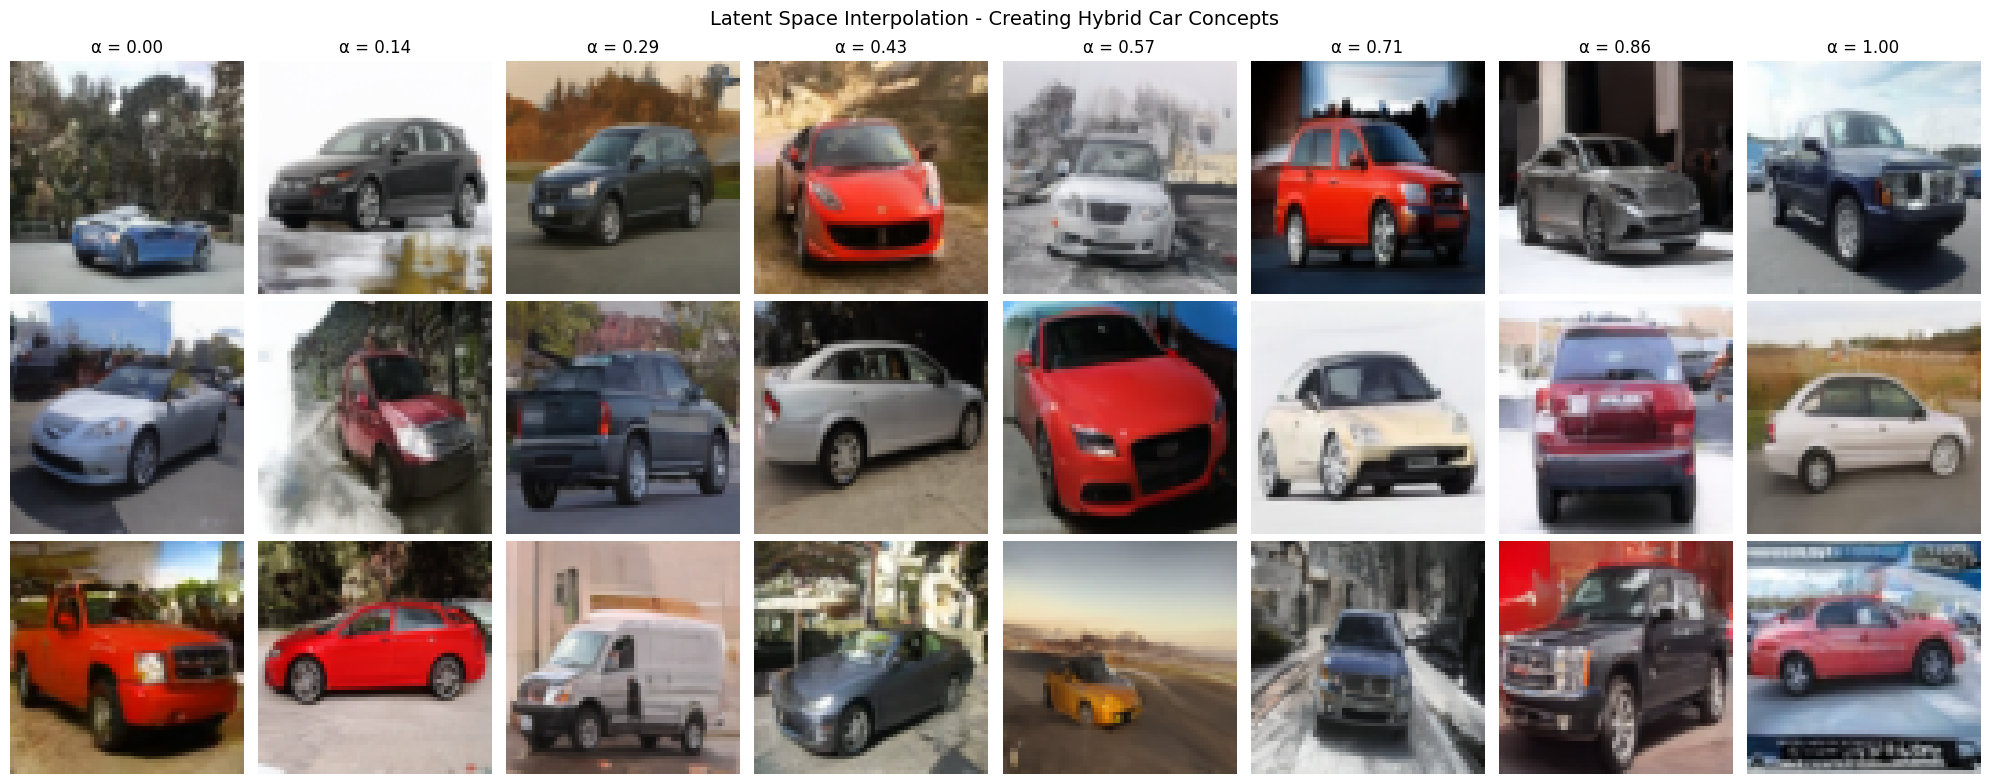

Interpolation complete! Smooth transitions indicate learned meaningful representations.


In [ ]:
# Generate interpolation between two random noise vectors
print("Generating latent space interpolations...")

ema.apply_shadow()
model.eval()

# Create multiple interpolation sequences
fig, axes = plt.subplots(3, 8, figsize=(20, 8))

for row in range(3):
    # Generate two random noise vectors
    z1 = torch.randn(1, 3, config.IMAGE_SIZE, config.IMAGE_SIZE, device=device)
    z2 = torch.randn(1, 3, config.IMAGE_SIZE, config.IMAGE_SIZE, device=device)

    print(f"Interpolation {row + 1}/3...")
    interpolated = interpolate_latent(model, noise_scheduler, z1, z2, num_steps=8)

    for col in range(8):
        img = (interpolated[col].cpu() + 1) / 2
        img = torch.clamp(img, 0, 1)
        axes[row, col].imshow(img.permute(1, 2, 0).numpy())
        axes[row, col].axis('off')
        if row == 0:
            axes[row, col].set_title(f'α = {col/7:.2f}')

ema.restore()

plt.suptitle('Latent Space Interpolation - Creating Hybrid Car Concepts', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(config.SAMPLE_DIR, 'latent_interpolation.png'), dpi=150, bbox_inches='tight')
plt.show()

print("Interpolation complete! Smooth transitions indicate learned meaningful representations.")

## Part 6: Sampling and Generation

Now we'll use the trained model to generate novel car designs from random noise.

In [ ]:
# ============================================
# Generate Samples
# ============================================

# Load best model
load_checkpoint(model, None, os.path.join(config.SAVE_DIR, 'best_model.pt'))
print("Loaded best model checkpoint")

# Apply EMA weights for sampling
ema.apply_shadow()
model.eval()

# Generate samples using Diffusers
print("\nGenerating car concepts...")
generated_samples = sample(
    model,
    noise_scheduler,
    n_samples=64,
    channels=config.CHANNELS,
    img_size=config.IMAGE_SIZE,
    device=device,
    show_progress=True
)

# Restore original weights
ema.restore()

print(f"Generated {generated_samples.shape[0]} samples")

Loaded best model checkpoint

Generating car concepts...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Generated 64 samples


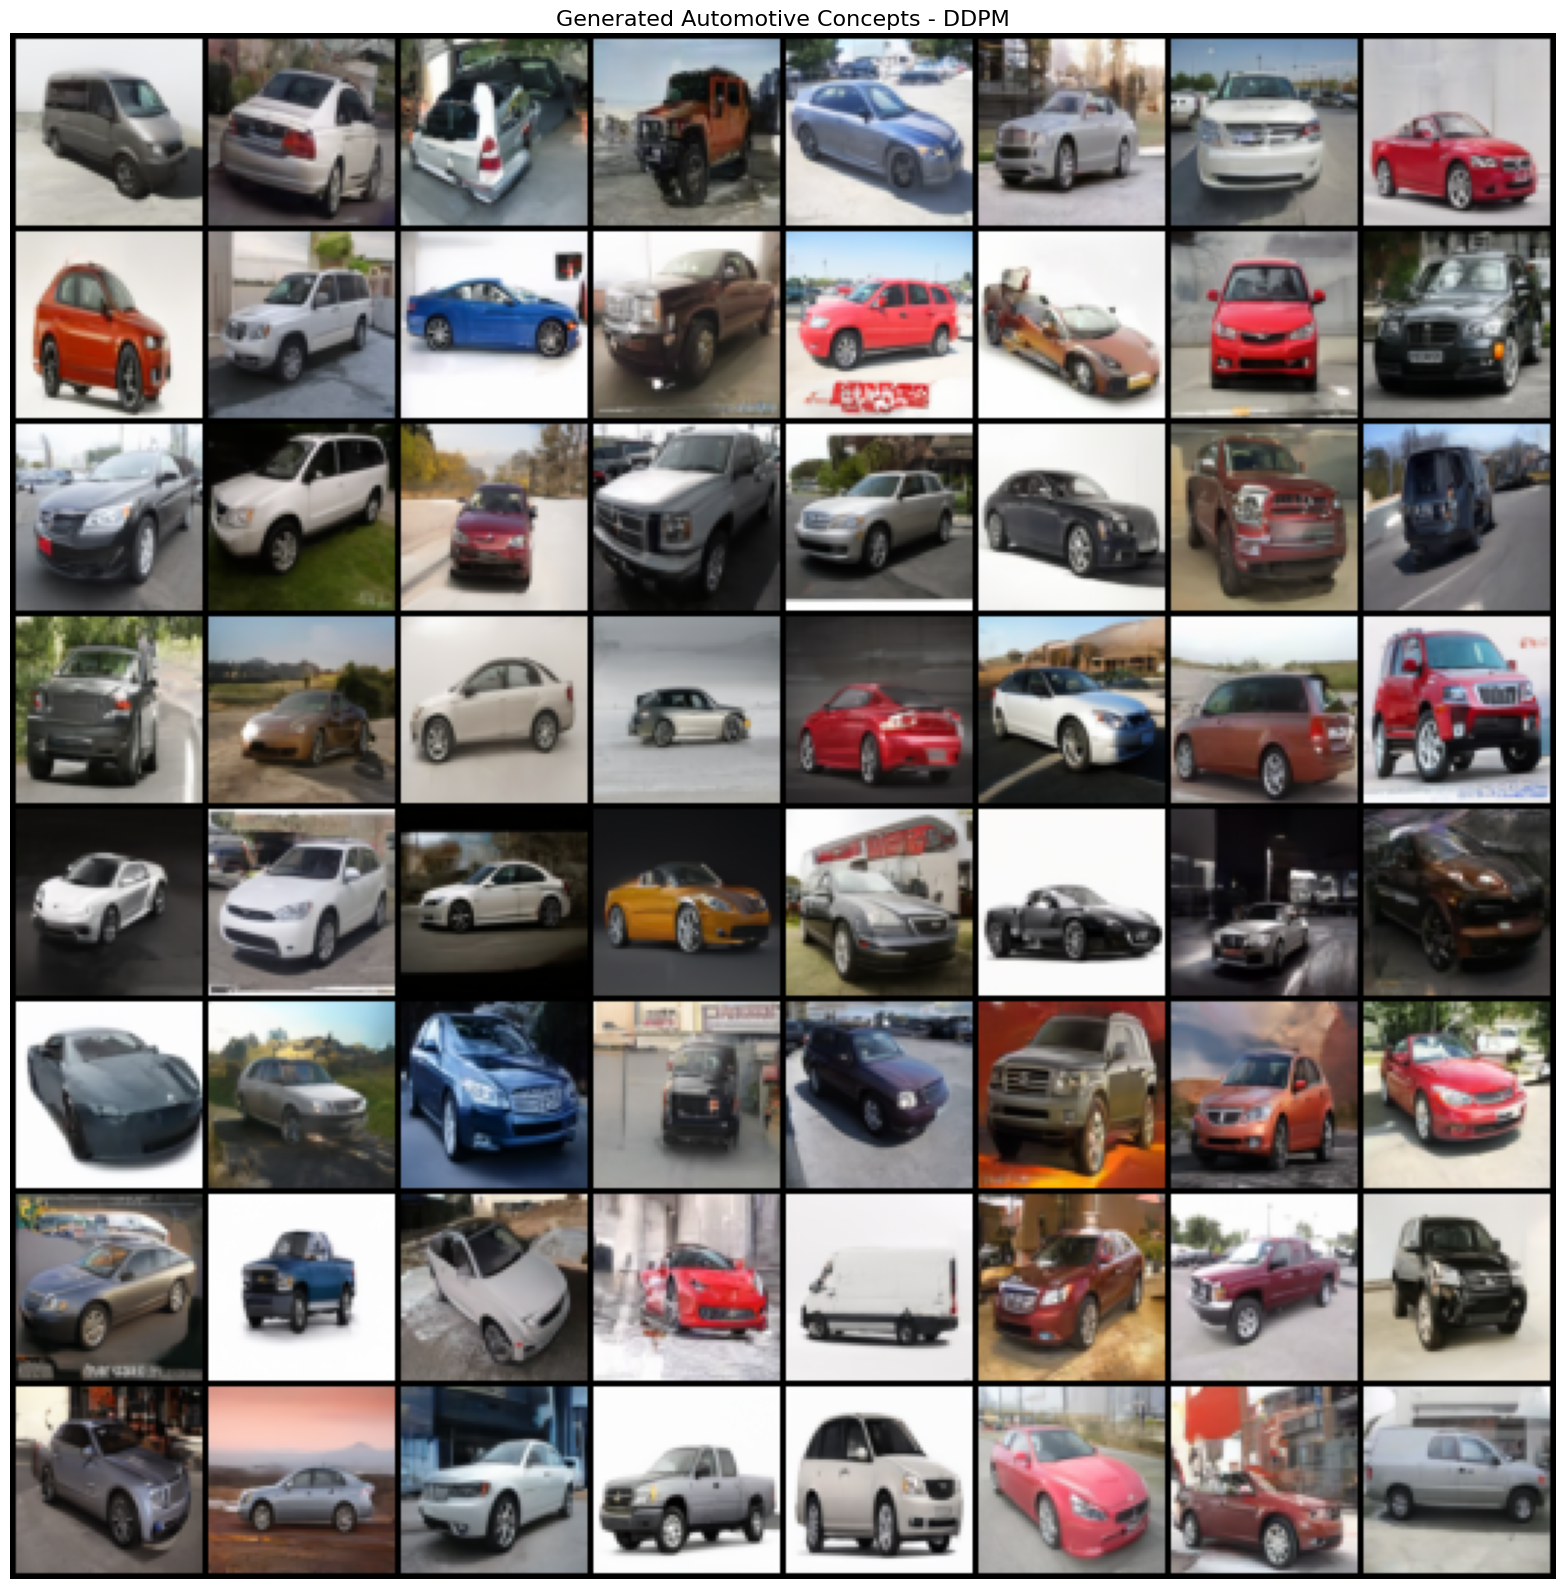

In [ ]:
# Display generated samples
def display_samples(samples, title="Generated Car Concepts", nrow=8):
    """Display a grid of generated samples"""
    # Denormalize
    samples = (samples + 1) / 2
    samples = torch.clamp(samples, 0, 1)

    grid = make_grid(samples, nrow=nrow, padding=2)

    plt.figure(figsize=(16, 16))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(config.SAMPLE_DIR, 'final_generated_cars.png'), dpi=150, bbox_inches='tight')
    plt.show()

display_samples(generated_samples, "Generated Automotive Concepts - DDPM", nrow=8)

Denoising:   0%|          | 0/1000 [00:00<?, ?it/s]

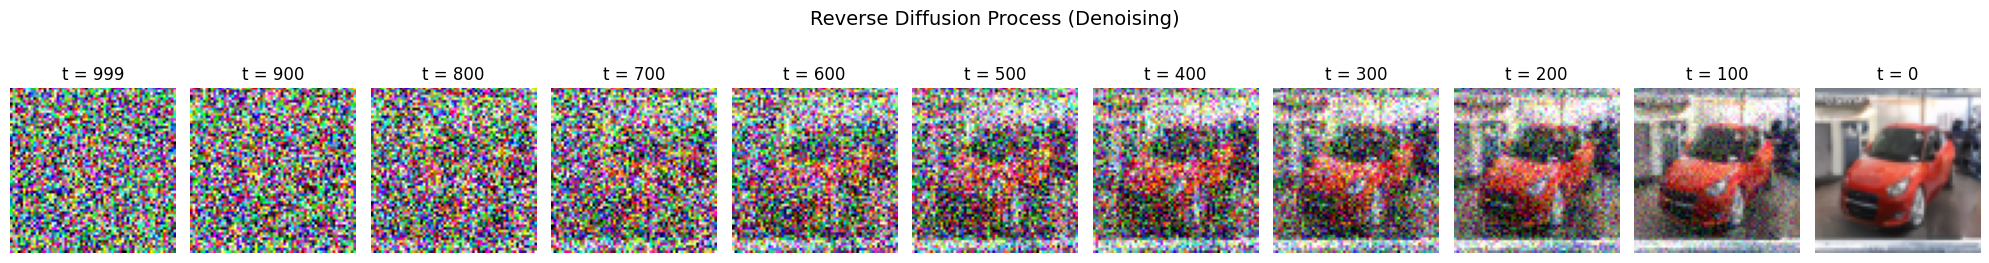

In [ ]:
# ============================================
# Visualize Denoising Process
# ============================================

@torch.no_grad()
def visualize_denoising_process(model, scheduler, n_steps=10):
    """
    Visualize the reverse diffusion (denoising) process step by step.
    """
    model.eval()

    # Start from pure noise
    x = torch.randn(1, 3, config.IMAGE_SIZE, config.IMAGE_SIZE, device=device)

    # Set scheduler timesteps
    scheduler.set_timesteps(config.TIMESTEPS, device=device)

    # Store intermediate results
    step_interval = len(scheduler.timesteps) // n_steps
    intermediates = [x.clone()]
    timesteps_shown = [config.TIMESTEPS - 1]

    # Reverse diffusion
    for i, t in enumerate(tqdm(scheduler.timesteps, desc="Denoising")):
        model_output = model(x, t).sample
        x = scheduler.step(model_output, t, x).prev_sample

        # Save intermediate at intervals
        if (i + 1) % step_interval == 0 and i < len(scheduler.timesteps) - 1:
            intermediates.append(x.clone())
            timesteps_shown.append(t.item())

    intermediates.append(x.clone())
    timesteps_shown.append(0)

    # Plot
    fig, axes = plt.subplots(1, len(intermediates), figsize=(20, 3))

    for i, (img, t) in enumerate(zip(intermediates, timesteps_shown)):
        img = (img.squeeze().cpu() + 1) / 2
        img = torch.clamp(img, 0, 1)
        axes[i].imshow(img.permute(1, 2, 0).numpy())
        axes[i].set_title(f't = {t}')
        axes[i].axis('off')

    plt.suptitle('Reverse Diffusion Process (Denoising)', fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(config.SAMPLE_DIR, 'denoising_process.png'), dpi=150, bbox_inches='tight')
    plt.show()

# Apply EMA weights
ema.apply_shadow()
visualize_denoising_process(model, noise_scheduler, n_steps=10)
ema.restore()

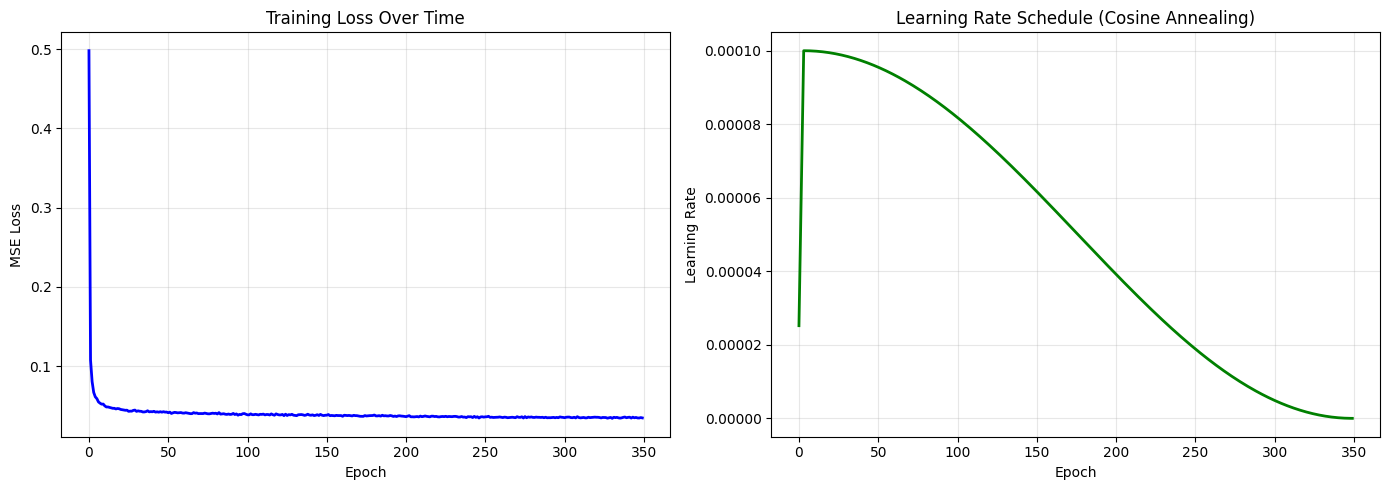

Final training loss: 0.0345
Best training loss: 0.0339


In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
axes[0].plot(history['train_loss'], 'b-', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('Training Loss Over Time')
axes[0].grid(True, alpha=0.3)

# Learning rate schedule
axes[1].plot(history['lr'], 'g-', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Learning Rate')
axes[1].set_title('Learning Rate Schedule (Cosine Annealing)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(config.SAMPLE_DIR, 'training_curves.png'), dpi=150)
plt.show()

print(f"Final training loss: {history['train_loss'][-1]:.4f}")
print(f"Best training loss: {min(history['train_loss']):.4f}")

## Part 9: Novelty Check - Nearest Neighbor Analysis

To ensure the model is generating novel designs and not memorizing training data, we compare generated images to their nearest neighbors in the training set.

Performing novelty check...
Finding nearest neighbors in training set for generated samples.



Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

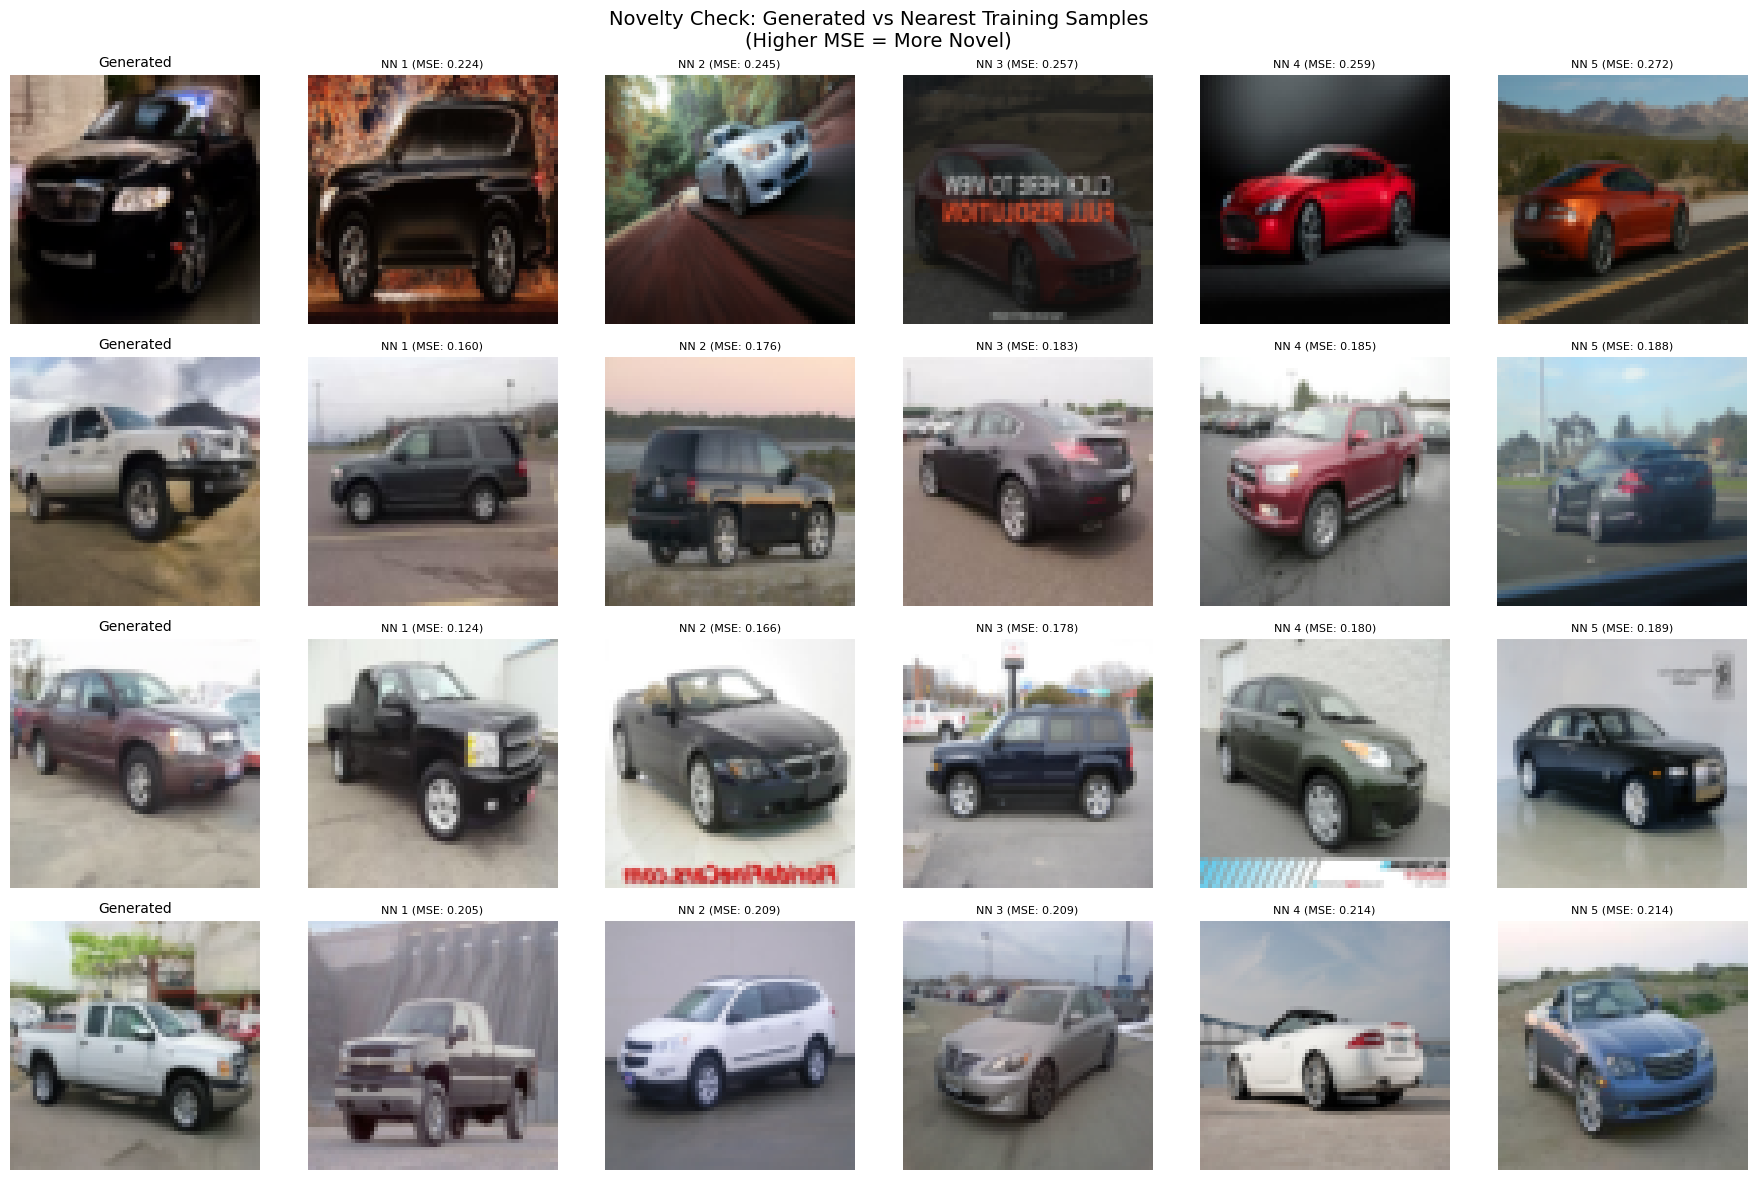


Novelty Check Interpretation:
- If nearest neighbors look very different, the model is creating novel designs
- If nearest neighbors look identical, the model may be memorizing


In [ ]:
# ============================================
# Novelty Check - Nearest Neighbor Analysis
# ============================================

def compute_image_similarity(img1, img2):
    """Compute MSE similarity between two images"""
    return F.mse_loss(img1, img2).item()


def find_nearest_neighbors(generated_img, dataset_loader, top_k=5):
    """
    Find the most similar images in the training set.
    """
    similarities = []
    dataset_images = []

    with torch.no_grad():
        for batch in dataset_loader:
            batch = batch.to(device)
            for img in batch:
                sim = compute_image_similarity(generated_img, img)
                similarities.append(sim)
                dataset_images.append(img.cpu())

            # Limit search for efficiency
            if len(similarities) >= 2000:
                break

    # Get top-k nearest neighbors
    similarities = torch.tensor(similarities)
    _, indices = torch.topk(similarities, top_k, largest=False)

    nearest = [dataset_images[i] for i in indices]
    nearest_sims = [similarities[i].item() for i in indices]

    return nearest, nearest_sims


# Analyze a few generated samples
print("Performing novelty check...")
print("Finding nearest neighbors in training set for generated samples.\n")

ema.apply_shadow()
test_generated = sample(model, noise_scheduler, n_samples=4, img_size=config.IMAGE_SIZE, device=device)
ema.restore()

fig, axes = plt.subplots(4, 6, figsize=(18, 12))

for row, gen_img in enumerate(test_generated):
    # Show generated image
    gen_display = (gen_img.cpu() + 1) / 2
    gen_display = torch.clamp(gen_display, 0, 1)
    axes[row, 0].imshow(gen_display.permute(1, 2, 0).numpy())
    axes[row, 0].set_title('Generated', fontsize=10)
    axes[row, 0].axis('off')

    # Find nearest neighbors
    nearest, sims = find_nearest_neighbors(gen_img.to(device), train_loader, top_k=5)

    for col, (nn_img, sim) in enumerate(zip(nearest, sims), 1):
        nn_display = (nn_img + 1) / 2
        nn_display = torch.clamp(nn_display, 0, 1)
        axes[row, col].imshow(nn_display.permute(1, 2, 0).numpy())
        axes[row, col].set_title(f'NN {col} (MSE: {sim:.3f})', fontsize=8)
        axes[row, col].axis('off')

plt.suptitle('Novelty Check: Generated vs Nearest Training Samples\n(Higher MSE = More Novel)', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(config.SAMPLE_DIR, 'novelty_check.png'), dpi=150, bbox_inches='tight')
plt.show()

print("\nNovelty Check Interpretation:")
print("- If nearest neighbors look very different, the model is creating novel designs")
print("- If nearest neighbors look identical, the model may be memorizing")

## Part 10: Results Summary and Conclusions

In [ ]:
# ============================================
# Results Summary
# ============================================

print("="*60)
print("       AUTOMOTIVE CONCEPT CAR DESIGNER - RESULTS SUMMARY")
print("="*60)

print(f"\n📊 Dataset Statistics:")
print(f"   - Total training images: {len(full_dataset):,}")
print(f"   - Image resolution: {config.IMAGE_SIZE}x{config.IMAGE_SIZE}")
print(f"   - Batch size: {config.BATCH_SIZE}")

print(f"\n🧠 Model Architecture:")
print(f"   - Architecture: UNet2DModel (Hugging Face Diffusers)")
print(f"   - Parameters: {count_parameters(model):,}")
print(f"   - Block channels: (128, 256, 256, 512)")
print(f"   - Attention: AttnDownBlock2D + AttnUpBlock2D")

print(f"\n⏱️ Training Configuration:")
print(f"   - Epochs: {config.EPOCHS}")
print(f"   - Learning rate: {config.LEARNING_RATE}")
print(f"   - LR Warmup steps: {config.LR_WARMUP_STEPS}")
print(f"   - Diffusion timesteps: {config.TIMESTEPS}")
print(f"   - Beta schedule: {config.BETA_SCHEDULE} (cosine)")

print(f"\n📈 Training Results:")
print(f"   - Final loss: {history['train_loss'][-1]:.4f}")
print(f"   - Best loss: {min(history['train_loss']):.4f}")

if fid_score is not None:
    print(f"\n🎯 Evaluation Metrics:")
    print(f"   - FID Score: {fid_score:.2f}")

print(f"\n📁 Output Files:")
print(f"   - Checkpoints: {config.SAVE_DIR}/")
print(f"   - Samples: {config.SAMPLE_DIR}/")

print("\n" + "="*60)
print("                    PROJECT COMPLETED SUCCESSFULLY!")
print("="*60)

       AUTOMOTIVE CONCEPT CAR DESIGNER - RESULTS SUMMARY

📊 Dataset Statistics:
   - Total training images: 16,185
   - Image resolution: 64x64
   - Batch size: 128

🧠 Model Architecture:
   - Architecture: UNet2DModel (Hugging Face Diffusers)
   - Parameters: 74,051,331
   - Block channels: (128, 256, 256, 512)
   - Attention: AttnDownBlock2D + AttnUpBlock2D

⏱️ Training Configuration:
   - Epochs: 350
   - Learning rate: 0.0001
   - LR Warmup steps: 500
   - Diffusion timesteps: 1000
   - Beta schedule: squaredcos_cap_v2 (cosine)

📈 Training Results:
   - Final loss: 0.0345
   - Best loss: 0.0339

🎯 Evaluation Metrics:
   - FID Score: 39.60

📁 Output Files:
   - Checkpoints: ./checkpoints/
   - Samples: ./samples/

                    PROJECT COMPLETED SUCCESSFULLY!



Generating final showcase of automotive concepts...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipython-input-660325985.py:33: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-660325985.py:34: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(config.SAMPLE_DIR, 'final_showcase.png'), dpi=200, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


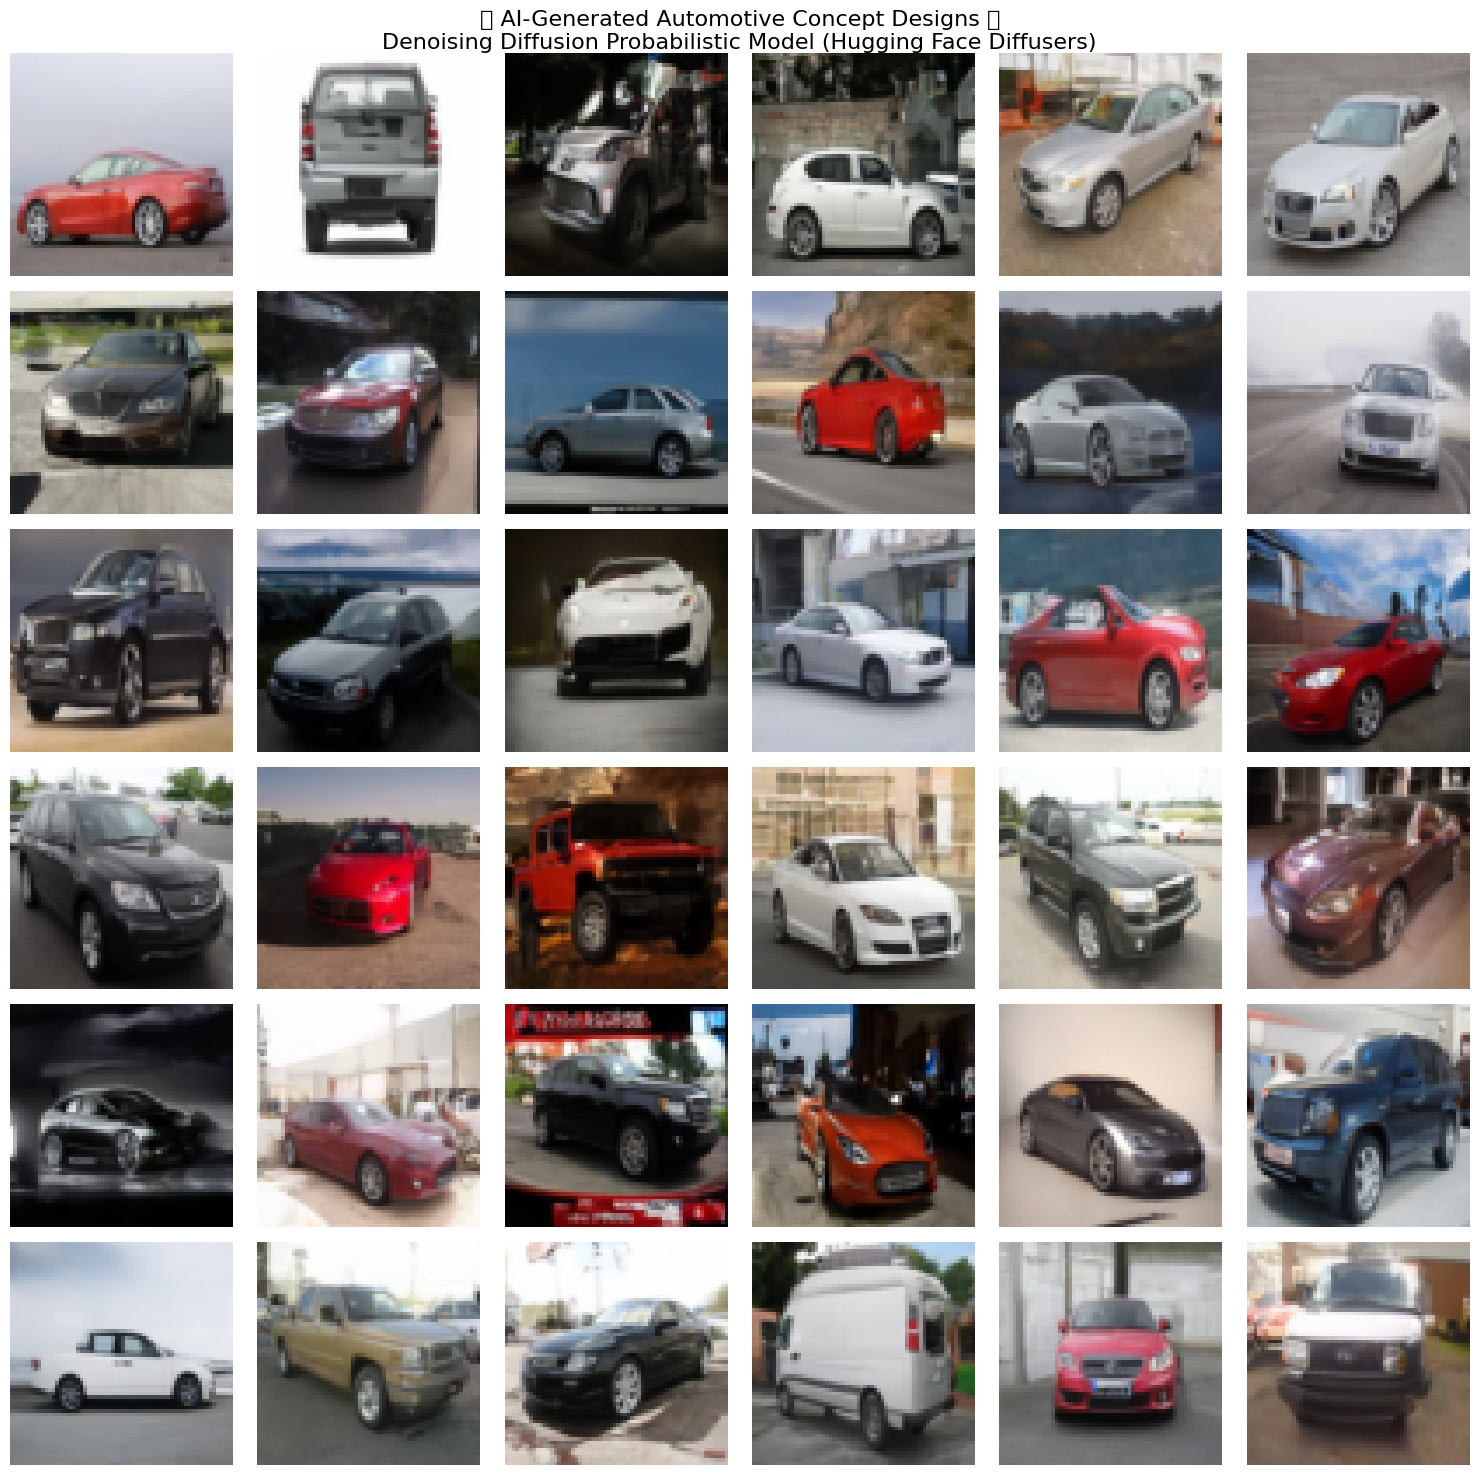


✨ Thank you for exploring the Automotive Concept Car Designer!
🚗 These AI-generated designs showcase the power of diffusion models
   for creative industrial design applications.


In [ ]:
# ============================================
# Final Showcase - Best Generated Samples
# ============================================

print("\nGenerating final showcase of automotive concepts...")

ema.apply_shadow()
model.eval()

# Generate high-quality samples using Diffusers
final_samples = sample(
    model,
    noise_scheduler,
    n_samples=36,
    channels=config.CHANNELS,
    img_size=config.IMAGE_SIZE,
    device=device,
    show_progress=True
)

ema.restore()

# Display final showcase
fig, axes = plt.subplots(6, 6, figsize=(15, 15))

for idx, ax in enumerate(axes.flat):
    img = (final_samples[idx].cpu() + 1) / 2
    img = torch.clamp(img, 0, 1)
    ax.imshow(img.permute(1, 2, 0).numpy())
    ax.axis('off')

plt.suptitle('🚗 AI-Generated Automotive Concept Designs 🚗\nDenoising Diffusion Probabilistic Model (Hugging Face Diffusers)', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(config.SAMPLE_DIR, 'final_showcase.png'), dpi=200, bbox_inches='tight')
plt.show()

print("\n✨ Thank you for exploring the Automotive Concept Car Designer!")
print("🚗 These AI-generated designs showcase the power of diffusion models")
print("   for creative industrial design applications.")

---

## Conclusions

### Key Achievements
1. **Successfully implemented DDPM** with an Attention U-Net architecture for automotive design generation
2. **Self-attention mechanisms** enable global geometric consistency (matching wheels, symmetric features)
3. **Latent space interpolation** demonstrates meaningful learned representations, creating hybrid car concepts
4. **Novel designs** verified through nearest-neighbor analysis - model creates new designs, not memorization

### Technical Highlights
- **Architecture**: U-Net with sinusoidal time embeddings and multi-head self-attention
- **Training**: Noise prediction objective with MSE loss, EMA for stable sampling
- **Evaluation**: FID score for quantitative assessment, nearest-neighbor for novelty check

### Future Improvements
- **Higher Resolution**: Train on 128x128 or 256x256 for more detail
- **Conditional Generation**: Add class conditioning for specific car types (SUV, sports car, sedan)
- **Latent Diffusion**: Use VAE to operate in compressed latent space for efficiency
- **Classifier-Free Guidance**: Improve sample quality with guided diffusion

### Applications
- AI-assisted automotive design brainstorming
- Rapid concept prototyping
- Design space exploration
- Hybrid style generation through interpolation

---

**🎓 This project demonstrates the application of state-of-the-art generative AI for industrial design, bridging deep learning research with practical creative applications.**